# Exploring activation functions

$\newcommand{\vct}[1]{\boldsymbol{#1}}
\newcommand{\mtx}[1]{\mathbf{#1}}
\newcommand{\tr}{^\mathrm{T}}
\newcommand{\reals}{\mathbb{R}}
\newcommand{\lpa}{\left(}
\newcommand{\rpa}{\right)}
\newcommand{\lsb}{\left[}
\newcommand{\rsb}{\right]}
\newcommand{\lbr}{\left\lbrace}
\newcommand{\rbr}{\right\rbrace}
\newcommand{\fset}[1]{\lbr #1 \rbr}
\newcommand{\pd}[2]{\frac{\partial #1}{\partial #2}}$

## Background

A neural network is composed of a number of layers, each implementing some transformation. The typical high level implementation of a single such layer (of basic type -> linear transformation plus non-linearity) can be formulated as follows:

\begin{equation}
    \vct{y} = \vct{f}(\mtx{W} \vct{x} + \vct{b})
    \qquad
    \Leftrightarrow
    \qquad
    y_k = f\lpa\sum_{d=1}^D \lpa W_{kd} x_d \rpa + b_k \rpa
\end{equation}

where $\mtx{W}$ and $\vct{b}$ parameterise an affine transformation, and $f$ is a function applied elementwise to the result of the affine transformation. For example a common choice for $f$ is the rectifier linear unit: 

\begin{equation}
  f(u) = max(0,u)
\end{equation}

One can stack an arbitrary number of such transformations, followed by an output layer. This means we can combine implementations of `AffineLayer` class with any non-linear function applied to the outputs just by implementing a layer object for the relevant non-linearity and then stacking the two layers together. 

To give a concrete example, in the `mlp.layers` module there is a definition for a `ReluLayer` equivalent to the following (documentation strings have been removed here for brevity)

```python
class ReluLayer(Layer):
    
    def fprop(self, inputs):
        return np.maximum(inputs, 0.)

    def bprop(self, inputs, outputs, grads_wrt_outputs):
        return (outputs > 0) * grads_wrt_outputs
```

As you can see this `ReluLayer` class has a very lightweight definition, defining just two key methods:

  * `fprop` which takes a batch of activations at the input to the layer and forward propagates them to produce activations at the outputs (directly equivalently to the `fprop` method of `AffineLayer`),
  * `brop` which takes a batch of gradients with respect to the outputs of the layer and back-propagates them to calculate gradients with respect to the inputs of the layer (explained in more detail below).
  
This `ReluLayer` class only implements the rectified linear transformation and so does not have any parameters. Therefore unlike `AffineLayer` it is derived directly from the base `Layer` class rather than `LayerWithParameters` and does not need to implement `grads_wrt_params` or `params` methods. 

To create a model consisting of an affine transformation followed by applying an elementwise rectified linear transformation you can first create a list of the two layer objects (in the order they are applied from inputs to outputs) and then use this to instantiate a new `MultipleLayerModel` object:

```python
from mlp.layers import AffineLayer, ReluLayer
from mlp.models import MultipleLayerModel

layers = [AffineLayer(INPUT_DIM, OUTPUT_DIM), ReluLayer()]
model = MultipleLayerModel(layers)
```

You can also stack an arbitrarily long sequence of layers together to produce deeper models. For instance the following would define a model consisting of three pairs of affine and rectified linear transformations.

```python
model = MultipleLayerModel([
    AffineLayer(INPUT_DIM, hidden_dim), ReluLayer(),
    AffineLayer(hidden_dim, hidden_dim), ReluLayer(),
    AffineLayer(hidden_dim, OUTPUT_DIM), ReluLayer(),
])
```

## Back-propagation of gradients
 The `bprop` method takes gradients of an error function with respect to the *outputs* of a layer and uses these gradients to calculate gradients of the error function with respect to the *inputs* of a layer. As the inputs to a non-input layer in a multiple-layer model consist of the outputs of the previous layer, this means we can calculate the gradients of the error function with respect to the outputs of every layer in the model by iteratively propagating the gradients backwards through the layers of the model (i.e. from the last to first layer).

For a layer with parameters, the gradients with respect to the layer outputs are required to calculate gradients with respect to the layer parameters. Therefore by combining back-propagation of gradients through the model with computing the gradients with respect to parameters in the relevant layers one can calculate gradients of the error function with respect to all of the parameters of a multiple-layer model in a very efficient manner.

## Imports & Plot Settings

In [1]:
import logging
import types

import numpy as np
import matplotlib.pyplot as plt
from scipy import misc

from mlp.layers import AffineLayer, SigmoidLayer, ReluLayer, EluLayer, SeluLayer, GeluLayer, IsrluLayer
from mlp.errors import CrossEntropyError, CrossEntropySoftmaxError
from mlp.models import SingleLayerModel, MultipleLayerModel
from mlp.initialisers import UniformInit, NormalInit
from mlp.learning_rules import GradientDescentLearningRule, MomentumLearningRule
from mlp.data_providers import MNISTDataProvider
from mlp.optimisers import Optimiser


%matplotlib inline
plt.style.use('ggplot')

## Linear Unit Equations

### Rectified Linear Unit (RELU)

\begin{equation}
  f\left(x\right) = \mathrm{max}(x, 0)   
\end{equation}

\begin{equation}
  f'\left(x\right) =
    \begin{cases}
      1 & \text{if } x > 0\\
      0 & \text{if } x \leq 0
    \end{cases}       
\end{equation}

### Exponential Linear Unit (ELU)

\begin{equation}
  f\left(x\right) =
    \begin{cases}
      x & \text{if } x > 0\\
      \alpha\left(\exp\left(x\right) - 1\right) & \text{if } x \leq 0
    \end{cases}       
\end{equation}

\begin{equation}
  f'\left(x\right) =
    \begin{cases}
      1 & \text{if } x > 0\\
      \alpha\exp\left(x\right) & \text{if } x \leq 0
    \end{cases}       
\end{equation}
* "ELUs have negative values which allows them to push mean unit activations closer to zero like batch normalization but with lower computational complexity"
* Paper: https://arxiv.org/abs/1511.07289 [2015]

### Scaled Exponential Linear Unit (SELU)

\begin{equation}
  f\left(x\right) = \lambda
    \begin{cases}
      x & \text{if } x > 0\\
      \alpha\left(\exp\left(x\right) - 1\right) & \text{if } x \leq 0
    \end{cases}       
\end{equation}

\begin{equation}
  f'\left(x\right) = \lambda
    \begin{cases}
      1 & \text{if } x > 0\\
      \alpha\exp\left(x\right) & \text{if } x \leq 0
    \end{cases}    
\end{equation}

 \begin{equation}
    \lambda = 1.05070098,\ \alpha = 1.67326324
\end{equation}
* "SNNs allows to (1) train deep networks with many layers, (2) employ strong regularization, and (3) to make learning highly robust"
* "Activations close to zero mean and unit variance that are propagated through many network layers will converge towards zero mean and unit variance"
* Example implementation for MNIST dataset: https://github.com/bioinf-jku/SNNs/blob/master/TF_2_x/MNIST-MLP-SELU.py
* Paper: https://arxiv.org/abs/1706.02515 [2017]

### Gaussian Error Linear Unit (GELU)

\begin{equation}
\begin{split}
  f\left(x\right) & = xP\left(X\leq x\right),\ X \sim \mathcal N(0,1) \\
  & = x\int_{-\infty}^xp(t)dt = x\phi(x) \\
  & = \frac{x}{2}\left[1 + \mathrm{erf}\left(\frac{x}{\sqrt{2}}\right)\right] \\
%   f\left(x\right) & \approx \frac{x}{2}\left(1 + \tanh\left[\sqrt{2}/\pi \left(x + 0.044715x^3\right)\right]\right)
\end{split}
\end{equation}

\begin{equation}
\begin{split}
 f'\left(x\right) & = \phi(x)\frac{dx}{dx} + x\phi'(x)=\phi(x)+xP\left(X=x\right) \\
 & = \frac{1 +  \mathrm{erf}\left(x / \sqrt{2}\right)}{2} + \frac{x}{\sqrt{2\pi}}\exp\left(-\frac{x^2}{2}\right)
\end{split}
\end{equation}
* "High-performing neural network activation function"
* "The GELU nonlinearity weights inputs by their value, rather than gates inputs by their sign as in ReLUs"
* Paper: https://arxiv.org/abs/1606.08415 [2016]

### Inverse Square Root Linear Unit (ISRLU)

\begin{equation}
  f\left(x\right) = 
    \begin{cases}
      x & \text{if } x > 0\\
      \frac{x}{\sqrt{1+\alpha x^2}} & \text{if } x \leq 0
    \end{cases}       
\end{equation}

\begin{equation}
  f'\left(x\right) =
    \begin{cases}
      1 & \text{if } x > 0\\
       \left(1+\alpha x^2\right)^{-3/2} & \text{if } x \leq 0
    \end{cases}       
\end{equation}
* "ISRLU has better performance than ELU but has many of
the same benefits"
* "Both have negative values, allowing them to push mean unit activation closer to zero,
and bring the normal gradient closer to the unit natural gradient, ensuring a noiserobust deactivation state, lessening the over fitting risk"
* Paper: https://arxiv.org/abs/1710.09967 [2017]

Verify analytical derivatives by comparing them to approximated derivatives using discrete forward difference


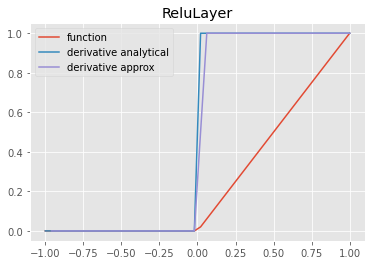

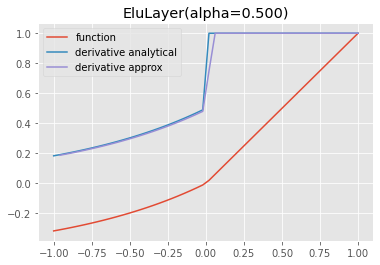

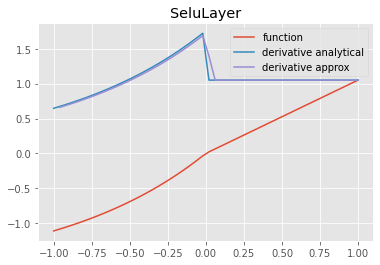

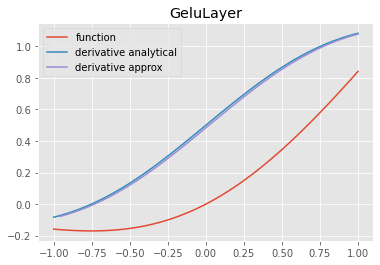

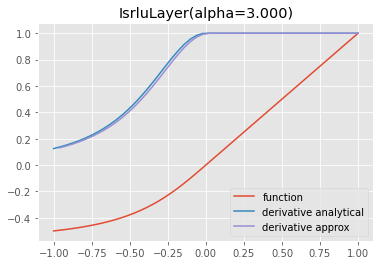

In [2]:
# Initialize a x vector in the range of [-1, 1]
x_vec = np.linspace(-1, 1)

def diff_fwd(x, y):
    """Descrete forward difference of vector y wtr to vector x."""
    return np.diff(y) / np.diff(x)

# Plot function, analytical and approximated derivatives 
for layer in (ReluLayer(), EluLayer(0.5), SeluLayer(), GeluLayer(), IsrluLayer(3)):
    y_vec = layer.fprop(x_vec)
    plt.plot(x_vec, y_vec, label="function")
    plt.plot(x_vec, layer.bprop(None, x_vec, 1), label="derivative analytical")
    plt.plot(x_vec[1:], diff_fwd(x_vec, y_vec), label="derivative approx")
    plt.title(layer)
    plt.legend()
    plt.show()

In [3]:
# Seed a random number generator
SEED = 6102016 
rng = np.random.RandomState(SEED)

# Set up a logger object to print info about the training run to stdout
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.handlers = [logging.StreamHandler()]

# Create data provider objects for the MNIST data set
train_data = MNISTDataProvider('train', rng=rng)
valid_data = MNISTDataProvider('valid', rng=rng)
# Note: for simplicity I'm NOT considering the test ata
test_data = MNISTDataProvider('test', rng=rng)
INPUT_DIM, OUTPUT_DIM = 784, 10

In [4]:
def train_model_and_plot_stats(
        model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval):

    # As well as monitoring the error over training also monitor classification
    # accuracy i.e. proportion of most-probable predicted classes being equal to targets
    data_monitors={'acc': lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}

    # Use the created objects to initialise a new Optimiser instance.
    optimiser = Optimiser(
        model, error, learning_rule, train_data, valid_data, data_monitors)

    # Run the optimiser for 5 epochs (full passes through the training set)
    # printing statistics every epoch.
    stats, keys, run_time = optimiser.train(num_epochs=num_epochs, stats_interval=stats_interval)

    # Plot the change in the validation and training set error over training.
    fig_1 = plt.figure(figsize=(8, 4))
    ax_1 = fig_1.add_subplot(111)
    for k in ['error(train)', 'error(valid)']:
        ax_1.plot(np.arange(1, stats.shape[0]) * stats_interval, 
                  stats[1:, keys[k]], label=k)
    ax_1.legend(loc=0)
    ax_1.set_xlabel('Epoch number')

    # Plot the change in the validation and training set accuracy over training.
    fig_2 = plt.figure(figsize=(8, 4))
    ax_2 = fig_2.add_subplot(111)
    for k in ['acc(train)', 'acc(valid)']:
        ax_2.plot(np.arange(1, stats.shape[0]) * stats_interval, 
                  stats[1:, keys[k]], label=k)
    ax_2.legend(loc=0)
    ax_2.set_xlabel('Epoch number')
    
    return stats, keys, run_time, fig_1, ax_1, fig_2, ax_2


Below we describe how to build multiple-layer model architectures for the MNIST classification task. 

```python
layers = [
    AffineLayer(INPUT_DIM, 100),
    ReluLayer(),
    AffineLayer(100, OUTPUT_DIM),
    ReluLayer()
]
```

An example cell:

In [54]:
final_errors_train = []
final_errors_valid = []
final_accs_train = []
final_accs_valid = []

def get_multiple_layer_model(activation_layer, hidden_dim, initializer, rng, n_hidden_layers=1, **kwargs):
    """Creates a model given the number of hidden layers, the hidden layer dimensions,
    the activation functions and initial weights."""
    assert n_hidden_layers > 0
    
    def get_param_init(in_dim, out_dim):
        if isinstance(initializer, types.FunctionType):
            param_init = initializer(in_dim, out_dim)
        else:
            param_init = initializer
        # Reset random value generator
        param_init.rng = rng
        return param_init
        
    param_init = get_param_init(INPUT_DIM, hidden_dim)
    
     # Add first hidden layer
    layers = [AffineLayer(INPUT_DIM, hidden_dim, param_init, param_init), activation_layer]
    in_dim = hidden_dim
    out_dim = hidden_dim
    for i in range(n_hidden_layers - 1):
        out_dim = int(in_dim / 2)
        param_init = get_param_init(in_dim, out_dim)
        layers += [AffineLayer(in_dim, out_dim, param_init, param_init), activation_layer]
        in_dim = out_dim
    # Add output layer
    param_init = get_param_init(out_dim, OUTPUT_DIM)
    layers += [AffineLayer(out_dim, OUTPUT_DIM, param_init, param_init)]
    return MultipleLayerModel(layers, **kwargs)

def run(activation_layer=ReluLayer(),
        n_hidden_layers=1,
        hidden_dim=100,
        learning_rate=0.2,
        initializer=UniformInit(-0.1, 0.1),
        regularizer=None,
        regularizer_lambda=1,
        learning_rule_cls=GradientDescentLearningRule,
        batch_size=100,
        num_epochs=100,
        stats_interval=5,
        train_data=train_data,
        valid_data=valid_data,
        rng=rng):
    """Run a model given a fixed hyper-parameter setting."""
    # Reset random number generator and data provider states on each run
    # to ensure reproducibility of results
    rng.seed(SEED)
    train_data.reset()
    valid_data.reset()

    model = get_multiple_layer_model(activation_layer,
                                     hidden_dim,
                                     initializer,
                                     rng=rng,
                                     n_hidden_layers=n_hidden_layers,
                                     regularizer=regularizer,
                                     regularizer_lambda=regularizer_lambda)

    # Alter data-provider batch size
    train_data.batch_size = batch_size
    valid_data.batch_size = batch_size

    # Initialise a cross entropy error object
    error = CrossEntropySoftmaxError(model)

    # Use a basic gradient descent learning rule
    learning_rule = learning_rule_cls(learning_rate=learning_rate)
    print('-' * 125)
    print(f' num_epochs={num_epochs} batch_size={batch_size} learning_rate={learning_rate:.3f} initializer={initializer} hidden_dim={hidden_dim} n_hidden_layers={n_hidden_layers}\n regularizer={regularizer} regularizer_lambda={regularizer_lambda}')        
    print('-' * 125)
    print(model)
    stats, keys, run_time, fig_1, ax_1, fig_2, ax_2 = train_model_and_plot_stats(
        model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval)
    plt.show()

    print(f'    final error(train) = {stats[-1, keys["error(train)"]]:.3e}')
    print(f'    final error(valid) = {stats[-1, keys["error(valid)"]]:.3e}')
    print(f'    final acc(train)   = {stats[-1, keys["acc(train)"]]:.3e}')
    print(f'    final acc(valid)   = {stats[-1, keys["acc(valid)"]]:.3e}')
    print(f'    run time per epoch = {run_time / num_epochs:.3f}')
    return model
    

def run_grid(activation_layers=[ReluLayer()],
             n_hidden_layers=[1],
             hidden_dims=[100],
             learning_rates=[0.2],
             initializers=[UniformInit(-0.1, 0.1)],
             regularizers=[None],
             regularizer_lambdas=[1],
             **kwargs):
    """Run models over a grid of a given a hyper-parameter set"""
    for activation_layer_cls in activation_layers:
        for n_hidden_layers_ in n_hidden_layers:
            for hidden_dim in hidden_dims:
                for learning_rate in learning_rates:
                    for initializer in initializers:
                        for regularizer in regularizers:
                            for regularizer_lambda in regularizer_lambdas:
                                run(activation_layer=activation_layer_cls,
                                    n_hidden_layers=n_hidden_layers_,
                                    hidden_dim=hidden_dim,
                                    learning_rate=learning_rate,
                                    initializer=initializer,
                                    regularizer=regularizer,
                                    regularizer_lambda=regularizer_lambda,
                                    **kwargs)

### Getting started
Run 2 simple models inspired by http://neuralnetworksanddeeplearning.com/ for 30 epochs

-----------------------------------------------------------------------------------------------------------------------------
 num_epochs=30 batch_size=10 learning_rate=0.500 initializer=NormalInit(0.000, 1.000) hidden_dim=30 n_hidden_layers=1
 regularizer=None regularizer_lambda=1
-----------------------------------------------------------------------------------------------------------------------------
MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=30)
    SigmoidLayer
    AffineLayer(input_dim=30, output_dim=10)
)


Experiment Progress: 100%|██████████| 30/30 [00:43<00:00,  1.46s/it]


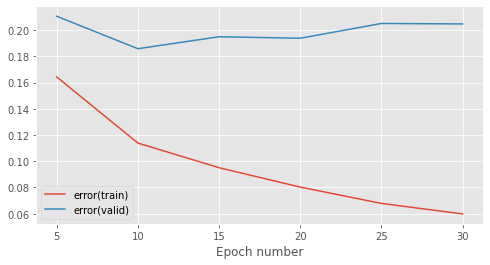

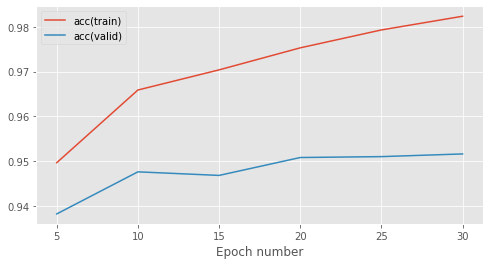

    final error(train) = 5.981e-02
    final error(valid) = 2.047e-01
    final acc(train)   = 9.824e-01
    final acc(valid)   = 9.516e-01
    run time per epoch = 1.499
-----------------------------------------------------------------------------------------------------------------------------
 num_epochs=30 batch_size=10 learning_rate=0.500 initializer=NormalInit(0.000, 1.000) hidden_dim=100 n_hidden_layers=1
 regularizer=None regularizer_lambda=1
-----------------------------------------------------------------------------------------------------------------------------
MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=100)
    SigmoidLayer
    AffineLayer(input_dim=100, output_dim=10)
)


Experiment Progress: 100%|██████████| 30/30 [01:22<00:00,  2.76s/it]


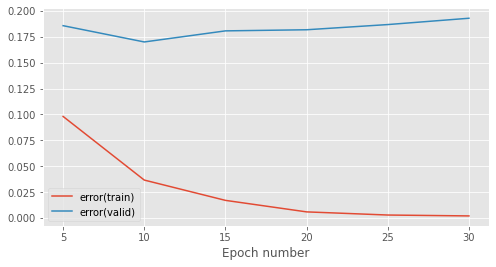

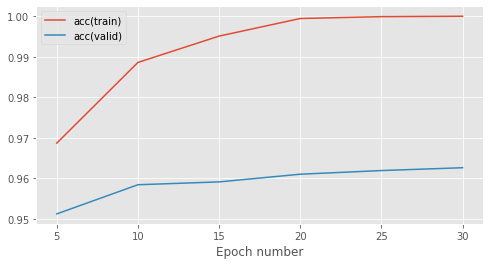

    final error(train) = 2.067e-03
    final error(valid) = 1.929e-01
    final acc(train)   = 1.000e+00
    final acc(valid)   = 9.626e-01
    run time per epoch = 2.806


MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=100)
    SigmoidLayer
    AffineLayer(input_dim=100, output_dim=10)
)

In [14]:
run(num_epochs=30, learning_rate=0.5, batch_size=10,
    initializer=NormalInit(0, 1, rng=rng), activation_layer=SigmoidLayer(), hidden_dim=30)
run(num_epochs=30, learning_rate=0.5, batch_size=10,
    initializer=NormalInit(0, 1, rng=rng), activation_layer=SigmoidLayer(), hidden_dim=100)

### Learning rate
Start with 2 hidden layers and vary learning-rate

-----------------------------------------------------------------------------------------------------------------------------
 num_epochs=100 batch_size=100 learning_rate=0.010 initializer=UniformInit(-0.100, 0.100) hidden_dim=100 n_hidden_layers=2
 regularizer=None regularizer_lambda=1
-----------------------------------------------------------------------------------------------------------------------------
MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=100)
    ReluLayer
    AffineLayer(input_dim=100, output_dim=50)
    ReluLayer
    AffineLayer(input_dim=50, output_dim=10)
)


Experiment Progress: 100%|██████████| 100/100 [01:26<00:00,  1.15it/s]


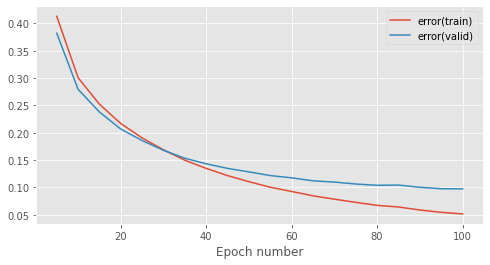

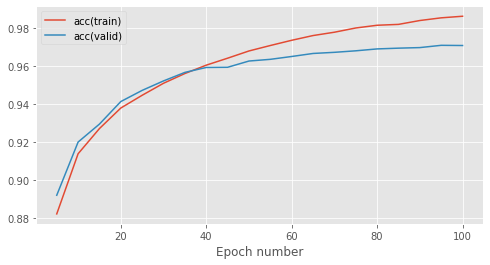

    final error(train) = 5.145e-02
    final error(valid) = 9.727e-02
    final acc(train)   = 9.865e-01
    final acc(valid)   = 9.710e-01
    run time per epoch = 0.871
-----------------------------------------------------------------------------------------------------------------------------
 num_epochs=100 batch_size=100 learning_rate=0.050 initializer=UniformInit(-0.100, 0.100) hidden_dim=100 n_hidden_layers=2
 regularizer=None regularizer_lambda=1
-----------------------------------------------------------------------------------------------------------------------------
MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=100)
    ReluLayer
    AffineLayer(input_dim=100, output_dim=50)
    ReluLayer
    AffineLayer(input_dim=50, output_dim=10)
)


Experiment Progress: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s]


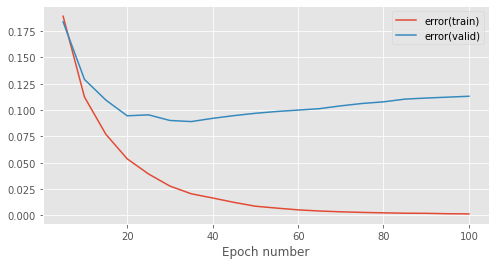

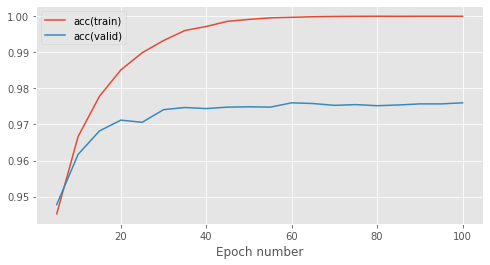

    final error(train) = 1.467e-03
    final error(valid) = 1.131e-01
    final acc(train)   = 1.000e+00
    final acc(valid)   = 9.760e-01
    run time per epoch = 0.866
-----------------------------------------------------------------------------------------------------------------------------
 num_epochs=100 batch_size=100 learning_rate=0.100 initializer=UniformInit(-0.100, 0.100) hidden_dim=100 n_hidden_layers=2
 regularizer=None regularizer_lambda=1
-----------------------------------------------------------------------------------------------------------------------------
MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=100)
    ReluLayer
    AffineLayer(input_dim=100, output_dim=50)
    ReluLayer
    AffineLayer(input_dim=50, output_dim=10)
)


Experiment Progress: 100%|██████████| 100/100 [01:27<00:00,  1.15it/s]


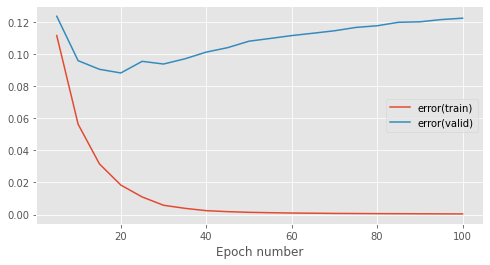

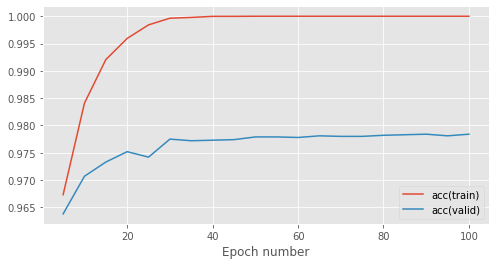

    final error(train) = 3.977e-04
    final error(valid) = 1.223e-01
    final acc(train)   = 1.000e+00
    final acc(valid)   = 9.784e-01
    run time per epoch = 0.877
-----------------------------------------------------------------------------------------------------------------------------
 num_epochs=100 batch_size=100 learning_rate=0.200 initializer=UniformInit(-0.100, 0.100) hidden_dim=100 n_hidden_layers=2
 regularizer=None regularizer_lambda=1
-----------------------------------------------------------------------------------------------------------------------------
MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=100)
    ReluLayer
    AffineLayer(input_dim=100, output_dim=50)
    ReluLayer
    AffineLayer(input_dim=50, output_dim=10)
)


Experiment Progress: 100%|██████████| 100/100 [01:40<00:00,  1.01s/it]


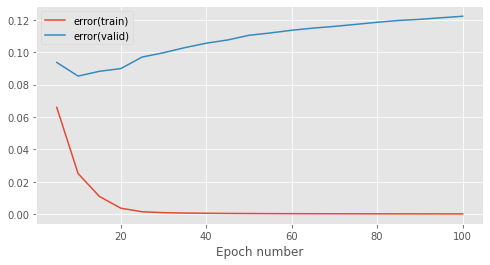

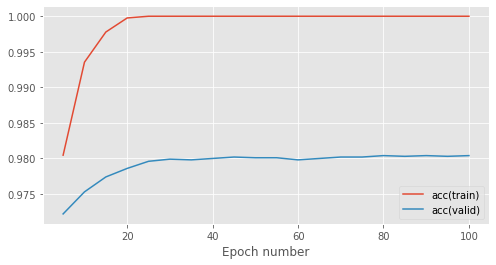

    final error(train) = 1.382e-04
    final error(valid) = 1.222e-01
    final acc(train)   = 1.000e+00
    final acc(valid)   = 9.804e-01
    run time per epoch = 1.011
-----------------------------------------------------------------------------------------------------------------------------
 num_epochs=100 batch_size=100 learning_rate=0.400 initializer=UniformInit(-0.100, 0.100) hidden_dim=100 n_hidden_layers=2
 regularizer=None regularizer_lambda=1
-----------------------------------------------------------------------------------------------------------------------------
MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=100)
    ReluLayer
    AffineLayer(input_dim=100, output_dim=50)
    ReluLayer
    AffineLayer(input_dim=50, output_dim=10)
)


Experiment Progress: 100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


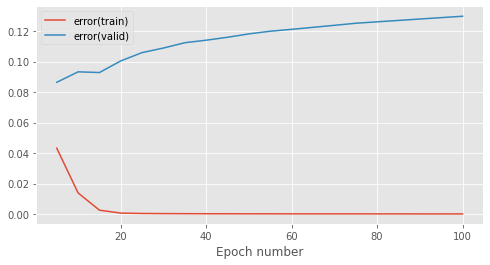

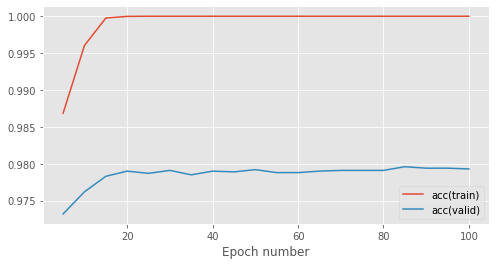

    final error(train) = 5.102e-05
    final error(valid) = 1.298e-01
    final acc(train)   = 1.000e+00
    final acc(valid)   = 9.793e-01
    run time per epoch = 0.978
-----------------------------------------------------------------------------------------------------------------------------
 num_epochs=100 batch_size=100 learning_rate=0.800 initializer=UniformInit(-0.100, 0.100) hidden_dim=100 n_hidden_layers=2
 regularizer=None regularizer_lambda=1
-----------------------------------------------------------------------------------------------------------------------------
MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=100)
    ReluLayer
    AffineLayer(input_dim=100, output_dim=50)
    ReluLayer
    AffineLayer(input_dim=50, output_dim=10)
)


Experiment Progress:  34%|███▍      | 34/100 [00:29<00:55,  1.20it/s]

In [ ]:
run_grid(learning_rates=(0.01, 0.05, 0.1, 0.2, 0.4, 0.8), n_hidden_layers=[2])
# Pick learning_rate=0.2

### Initialization scales
Vary initial scales

-----------------------------------------------------------------------------------------------------------------------------
 num_epochs=100 batch_size=100 learning_rate=0.200 initializer=UniformInit(-0.010, 0.010) hidden_dim=100 n_hidden_layers=2
 regularizer=None regularizer_lambda=1
-----------------------------------------------------------------------------------------------------------------------------
MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=100)
    ReluLayer
    AffineLayer(input_dim=100, output_dim=50)
    ReluLayer
    AffineLayer(input_dim=50, output_dim=10)
)


Experiment Progress: 100%|██████████| 100/100 [01:27<00:00,  1.14it/s]


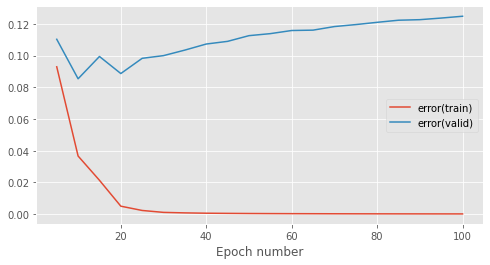

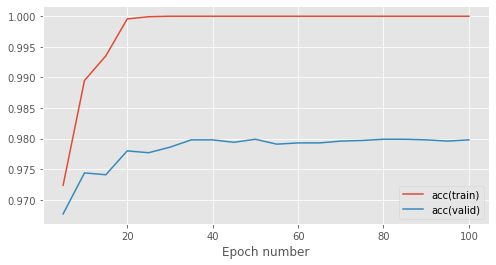

    final error(train) = 1.407e-04
    final error(valid) = 1.248e-01
    final acc(train)   = 1.000e+00
    final acc(valid)   = 9.798e-01
    run time per epoch = 0.883
-----------------------------------------------------------------------------------------------------------------------------
 num_epochs=100 batch_size=100 learning_rate=0.200 initializer=UniformInit(-0.020, 0.020) hidden_dim=100 n_hidden_layers=2
 regularizer=None regularizer_lambda=1
-----------------------------------------------------------------------------------------------------------------------------
MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=100)
    ReluLayer
    AffineLayer(input_dim=100, output_dim=50)
    ReluLayer
    AffineLayer(input_dim=50, output_dim=10)
)


Experiment Progress: 100%|██████████| 100/100 [01:29<00:00,  1.12it/s]


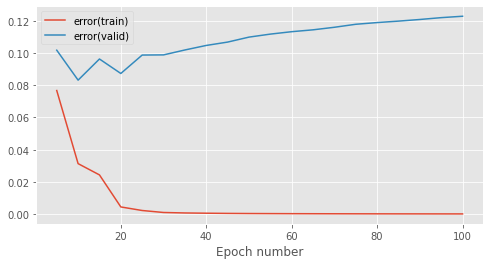

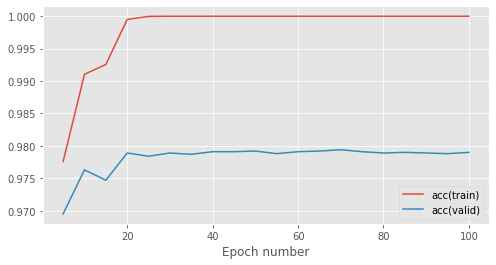

    final error(train) = 1.381e-04
    final error(valid) = 1.228e-01
    final acc(train)   = 1.000e+00
    final acc(valid)   = 9.790e-01
    run time per epoch = 0.897
-----------------------------------------------------------------------------------------------------------------------------
 num_epochs=100 batch_size=100 learning_rate=0.200 initializer=UniformInit(-0.040, 0.040) hidden_dim=100 n_hidden_layers=2
 regularizer=None regularizer_lambda=1
-----------------------------------------------------------------------------------------------------------------------------
MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=100)
    ReluLayer
    AffineLayer(input_dim=100, output_dim=50)
    ReluLayer
    AffineLayer(input_dim=50, output_dim=10)
)


Experiment Progress: 100%|██████████| 100/100 [01:36<00:00,  1.03it/s]


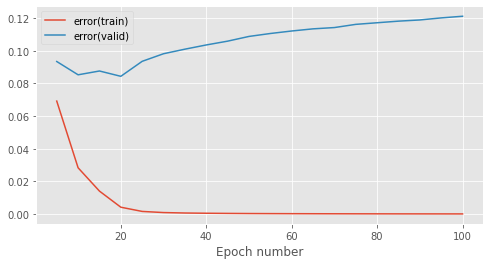

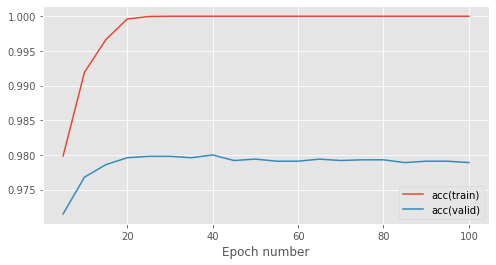

    final error(train) = 1.337e-04
    final error(valid) = 1.211e-01
    final acc(train)   = 1.000e+00
    final acc(valid)   = 9.789e-01
    run time per epoch = 0.972
-----------------------------------------------------------------------------------------------------------------------------
 num_epochs=100 batch_size=100 learning_rate=0.200 initializer=UniformInit(-0.080, 0.080) hidden_dim=100 n_hidden_layers=2
 regularizer=None regularizer_lambda=1
-----------------------------------------------------------------------------------------------------------------------------
MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=100)
    ReluLayer
    AffineLayer(input_dim=100, output_dim=50)
    ReluLayer
    AffineLayer(input_dim=50, output_dim=10)
)


Experiment Progress: 100%|██████████| 100/100 [01:36<00:00,  1.04it/s]


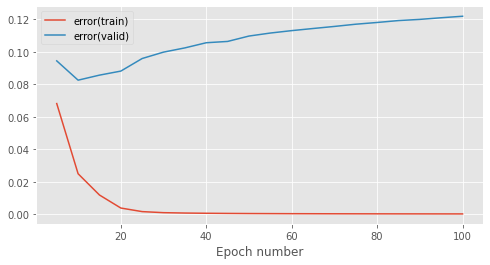

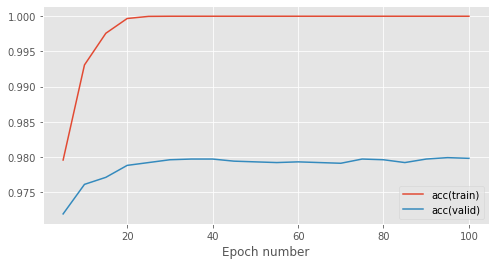

    final error(train) = 1.348e-04
    final error(valid) = 1.219e-01
    final acc(train)   = 1.000e+00
    final acc(valid)   = 9.798e-01
    run time per epoch = 0.965
-----------------------------------------------------------------------------------------------------------------------------
 num_epochs=100 batch_size=100 learning_rate=0.200 initializer=UniformInit(-0.160, 0.160) hidden_dim=100 n_hidden_layers=2
 regularizer=None regularizer_lambda=1
-----------------------------------------------------------------------------------------------------------------------------
MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=100)
    ReluLayer
    AffineLayer(input_dim=100, output_dim=50)
    ReluLayer
    AffineLayer(input_dim=50, output_dim=10)
)


Experiment Progress: 100%|██████████| 100/100 [01:34<00:00,  1.05it/s]


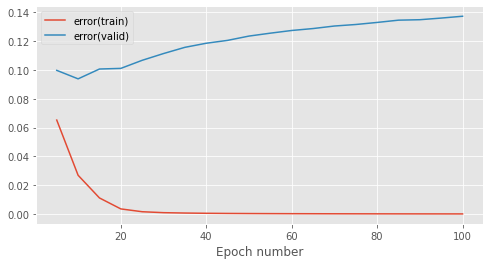

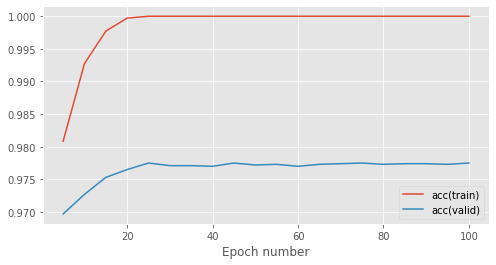

    final error(train) = 1.483e-04
    final error(valid) = 1.373e-01
    final acc(train)   = 1.000e+00
    final acc(valid)   = 9.775e-01
    run time per epoch = 0.955


In [26]:
run_grid(learning_rates=[0.2],
         initializers=[UniformInit(-init_scale, init_scale) for init_scale in (0.01, 0.02, 0.04, 0.08, 0.16)],
         n_hidden_layers=[2])
# Pick init_scale=0.1

### Hidden layer dimension
Vary dimension of hidden layers

-----------------------------------------------------------------------------------------------------------------------------
 num_epochs=100 batch_size=100 learning_rate=0.200 initializer=UniformInit(-0.100, 0.100) hidden_dim=80 n_hidden_layers=2
 regularizer=None regularizer_lambda=1
-----------------------------------------------------------------------------------------------------------------------------
MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=80)
    ReluLayer
    AffineLayer(input_dim=80, output_dim=40)
    ReluLayer
    AffineLayer(input_dim=40, output_dim=10)
)


Experiment Progress: 100%|██████████| 100/100 [01:19<00:00,  1.25it/s]


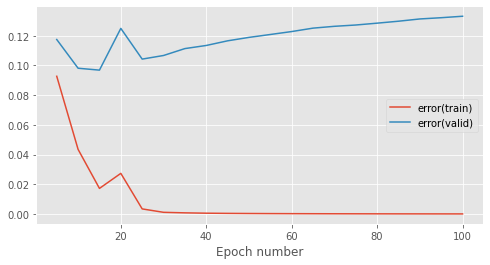

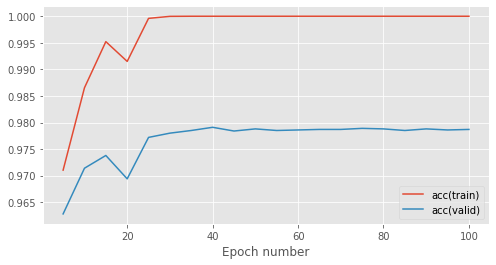

    final error(train) = 1.522e-04
    final error(valid) = 1.331e-01
    final acc(train)   = 1.000e+00
    final acc(valid)   = 9.787e-01
    run time per epoch = 0.802
-----------------------------------------------------------------------------------------------------------------------------
 num_epochs=100 batch_size=100 learning_rate=0.200 initializer=UniformInit(-0.100, 0.100) hidden_dim=100 n_hidden_layers=2
 regularizer=None regularizer_lambda=1
-----------------------------------------------------------------------------------------------------------------------------
MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=100)
    ReluLayer
    AffineLayer(input_dim=100, output_dim=50)
    ReluLayer
    AffineLayer(input_dim=50, output_dim=10)
)


Experiment Progress: 100%|██████████| 100/100 [01:33<00:00,  1.07it/s]


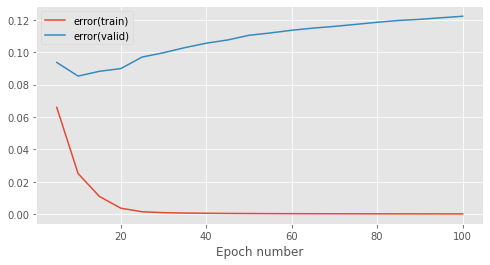

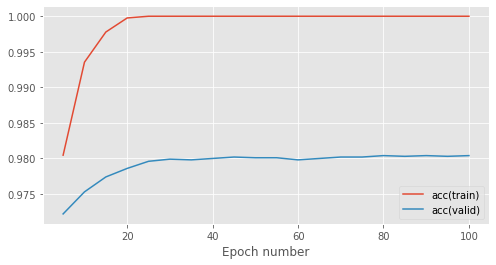

    final error(train) = 1.382e-04
    final error(valid) = 1.222e-01
    final acc(train)   = 1.000e+00
    final acc(valid)   = 9.804e-01
    run time per epoch = 0.940
-----------------------------------------------------------------------------------------------------------------------------
 num_epochs=100 batch_size=100 learning_rate=0.200 initializer=UniformInit(-0.100, 0.100) hidden_dim=150 n_hidden_layers=2
 regularizer=None regularizer_lambda=1
-----------------------------------------------------------------------------------------------------------------------------
MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=150)
    ReluLayer
    AffineLayer(input_dim=150, output_dim=75)
    ReluLayer
    AffineLayer(input_dim=75, output_dim=10)
)


Experiment Progress: 100%|██████████| 100/100 [02:04<00:00,  1.25s/it]


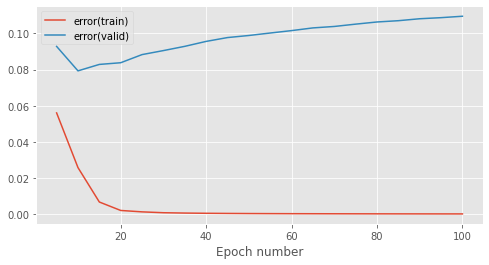

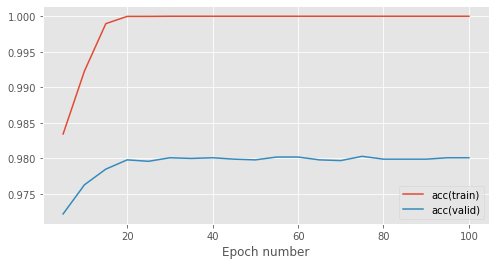

    final error(train) = 1.287e-04
    final error(valid) = 1.095e-01
    final acc(train)   = 1.000e+00
    final acc(valid)   = 9.801e-01
    run time per epoch = 1.252
-----------------------------------------------------------------------------------------------------------------------------
 num_epochs=100 batch_size=100 learning_rate=0.200 initializer=UniformInit(-0.100, 0.100) hidden_dim=200 n_hidden_layers=2
 regularizer=None regularizer_lambda=1
-----------------------------------------------------------------------------------------------------------------------------
MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=200)
    ReluLayer
    AffineLayer(input_dim=200, output_dim=100)
    ReluLayer
    AffineLayer(input_dim=100, output_dim=10)
)


Experiment Progress: 100%|██████████| 100/100 [02:29<00:00,  1.50s/it]


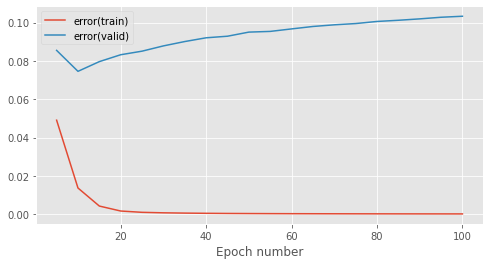

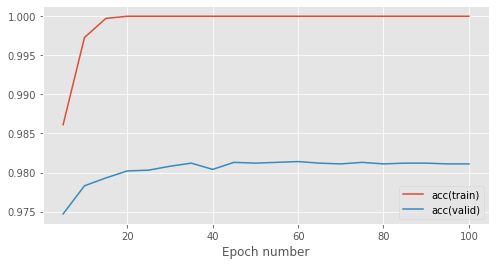

    final error(train) = 1.213e-04
    final error(valid) = 1.033e-01
    final acc(train)   = 1.000e+00
    final acc(valid)   = 9.811e-01
    run time per epoch = 1.503
-----------------------------------------------------------------------------------------------------------------------------
 num_epochs=100 batch_size=100 learning_rate=0.200 initializer=UniformInit(-0.100, 0.100) hidden_dim=250 n_hidden_layers=2
 regularizer=None regularizer_lambda=1
-----------------------------------------------------------------------------------------------------------------------------
MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=250)
    ReluLayer
    AffineLayer(input_dim=250, output_dim=125)
    ReluLayer
    AffineLayer(input_dim=125, output_dim=10)
)


Experiment Progress: 100%|██████████| 100/100 [03:03<00:00,  1.84s/it]


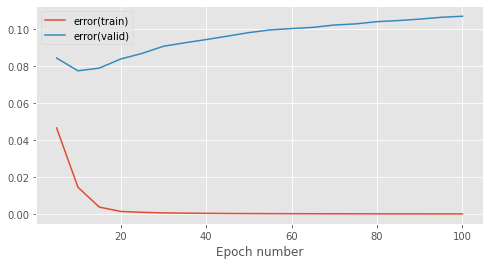

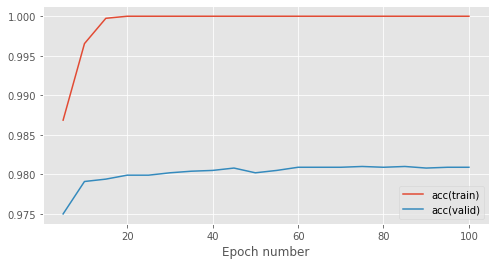

    final error(train) = 1.205e-04
    final error(valid) = 1.071e-01
    final acc(train)   = 1.000e+00
    final acc(valid)   = 9.809e-01
    run time per epoch = 1.843
-----------------------------------------------------------------------------------------------------------------------------
 num_epochs=100 batch_size=100 learning_rate=0.200 initializer=UniformInit(-0.100, 0.100) hidden_dim=300 n_hidden_layers=2
 regularizer=None regularizer_lambda=1
-----------------------------------------------------------------------------------------------------------------------------
MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=300)
    ReluLayer
    AffineLayer(input_dim=300, output_dim=150)
    ReluLayer
    AffineLayer(input_dim=150, output_dim=10)
)


Experiment Progress: 100%|██████████| 100/100 [03:31<00:00,  2.12s/it]


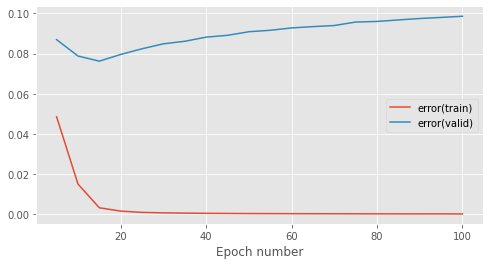

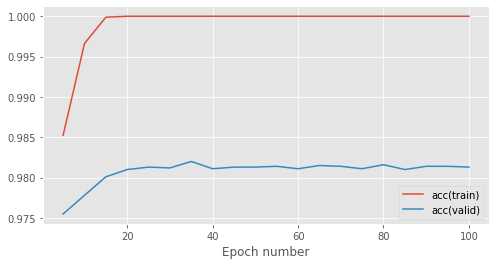

    final error(train) = 1.185e-04
    final error(valid) = 9.858e-02
    final acc(train)   = 1.000e+00
    final acc(valid)   = 9.813e-01
    run time per epoch = 2.128


In [27]:
run_grid(learning_rates=[0.2],
         initializers=[UniformInit(-0.1, 0.1)],
         hidden_dims=[80, 100, 150, 200, 250, 300],
         n_hidden_layers=[2])
# Pick hidden_dims=300

### Hidden layers
Vary number of hidden layers

-----------------------------------------------------------------------------------------------------------------------------
 num_epochs=100 batch_size=100 learning_rate=0.200 initializer=UniformInit(-0.100, 0.100) hidden_dim=300 n_hidden_layers=1
 regularizer=None regularizer_lambda=1
-----------------------------------------------------------------------------------------------------------------------------
MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=300)
    ReluLayer
    AffineLayer(input_dim=300, output_dim=10)
)


Experiment Progress: 100%|██████████| 100/100 [02:57<00:00,  1.78s/it]


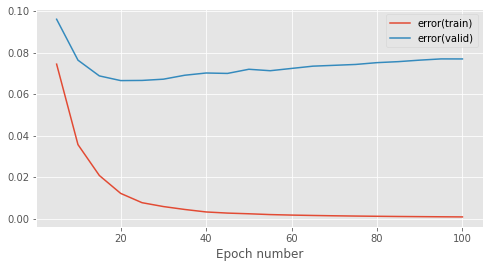

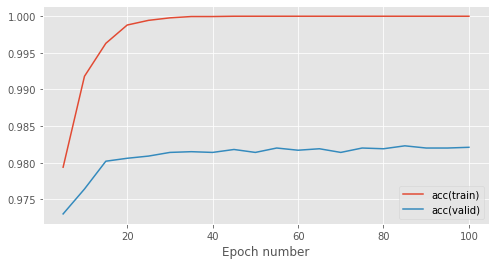

    final error(train) = 8.465e-04
    final error(valid) = 7.692e-02
    final acc(train)   = 1.000e+00
    final acc(valid)   = 9.821e-01
    run time per epoch = 1.785
-----------------------------------------------------------------------------------------------------------------------------
 num_epochs=100 batch_size=100 learning_rate=0.200 initializer=UniformInit(-0.100, 0.100) hidden_dim=300 n_hidden_layers=2
 regularizer=None regularizer_lambda=1
-----------------------------------------------------------------------------------------------------------------------------
MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=300)
    ReluLayer
    AffineLayer(input_dim=300, output_dim=150)
    ReluLayer
    AffineLayer(input_dim=150, output_dim=10)
)


Experiment Progress: 100%|██████████| 100/100 [03:19<00:00,  1.99s/it]


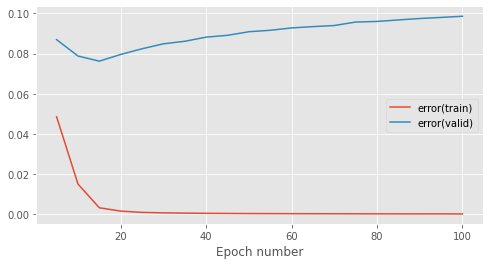

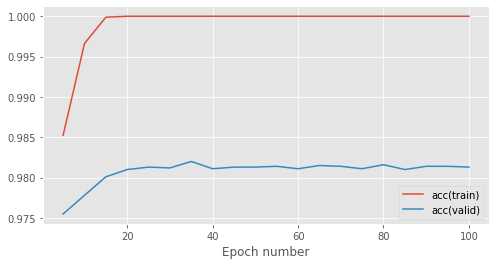

    final error(train) = 1.185e-04
    final error(valid) = 9.858e-02
    final acc(train)   = 1.000e+00
    final acc(valid)   = 9.813e-01
    run time per epoch = 2.001
-----------------------------------------------------------------------------------------------------------------------------
 num_epochs=100 batch_size=100 learning_rate=0.200 initializer=UniformInit(-0.100, 0.100) hidden_dim=300 n_hidden_layers=4
 regularizer=None regularizer_lambda=1
-----------------------------------------------------------------------------------------------------------------------------
MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=300)
    ReluLayer
    AffineLayer(input_dim=300, output_dim=150)
    ReluLayer
    AffineLayer(input_dim=150, output_dim=75)
    ReluLayer
    AffineLayer(input_dim=75, output_dim=37)
    ReluLayer
    AffineLayer(input_dim=37, output_dim=10)
)


Experiment Progress: 100%|██████████| 100/100 [03:33<00:00,  2.13s/it]


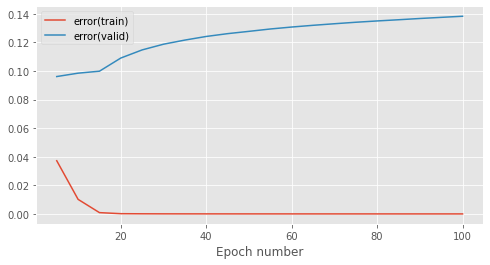

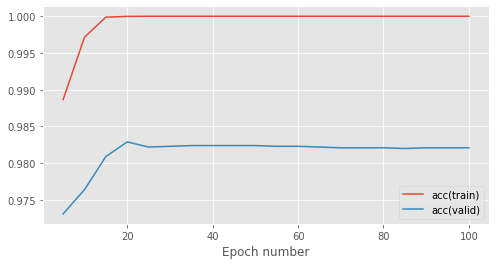

    final error(train) = 1.145e-05
    final error(valid) = 1.382e-01
    final acc(train)   = 1.000e+00
    final acc(valid)   = 9.821e-01
    run time per epoch = 2.143


In [82]:
run_grid(learning_rates=[0.2],
         initializers=[UniformInit(-0.1, 0.1)],
         hidden_dims=[300],
         n_hidden_layers=[1, 2, 4])
# Pick n_hidden_layers=1

### Baseline model
Search around in some reasonable hyper-parameter space

-----------------------------------------------------------------------------------------------------------------------------
 num_epochs=100 batch_size=100 learning_rate=0.100 initializer=UniformInit(-0.050, 0.050) hidden_dim=150 n_hidden_layers=1
 regularizer=None regularizer_lambda=1
-----------------------------------------------------------------------------------------------------------------------------
MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=150)
    ReluLayer
    AffineLayer(input_dim=150, output_dim=10)
)


Experiment Progress: 100%|██████████| 100/100 [01:33<00:00,  1.07it/s]


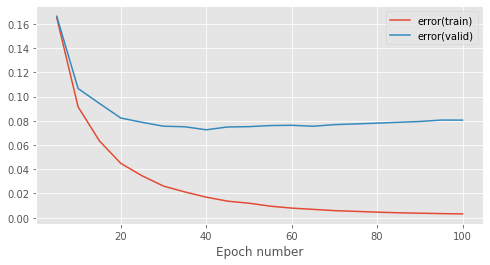

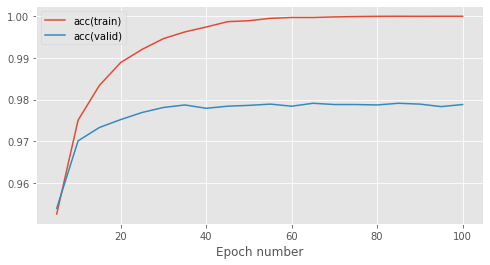

    final error(train) = 3.132e-03
    final error(valid) = 8.061e-02
    final acc(train)   = 1.000e+00
    final acc(valid)   = 9.788e-01
    run time per epoch = 0.943
-----------------------------------------------------------------------------------------------------------------------------
 num_epochs=100 batch_size=100 learning_rate=0.100 initializer=UniformInit(-0.100, 0.100) hidden_dim=150 n_hidden_layers=1
 regularizer=None regularizer_lambda=1
-----------------------------------------------------------------------------------------------------------------------------
MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=150)
    ReluLayer
    AffineLayer(input_dim=150, output_dim=10)
)


Experiment Progress: 100%|██████████| 100/100 [01:34<00:00,  1.05it/s]


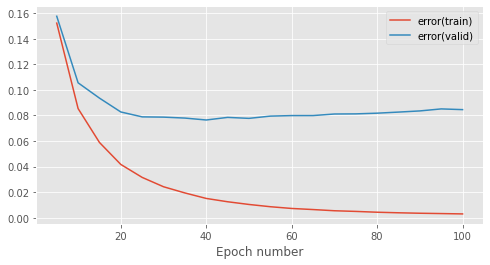

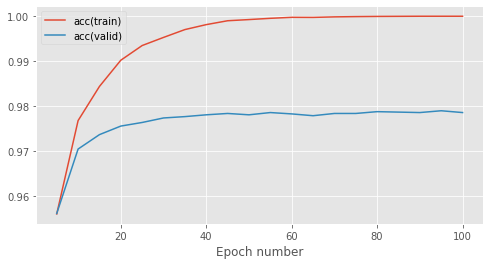

    final error(train) = 2.942e-03
    final error(valid) = 8.453e-02
    final acc(train)   = 1.000e+00
    final acc(valid)   = 9.786e-01
    run time per epoch = 0.953
-----------------------------------------------------------------------------------------------------------------------------
 num_epochs=100 batch_size=100 learning_rate=0.100 initializer=UniformInit(-0.200, 0.200) hidden_dim=150 n_hidden_layers=1
 regularizer=None regularizer_lambda=1
-----------------------------------------------------------------------------------------------------------------------------
MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=150)
    ReluLayer
    AffineLayer(input_dim=150, output_dim=10)
)


Experiment Progress: 100%|██████████| 100/100 [01:34<00:00,  1.06it/s]


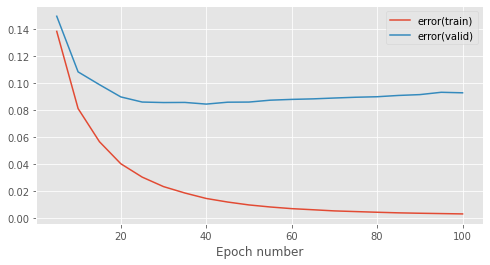

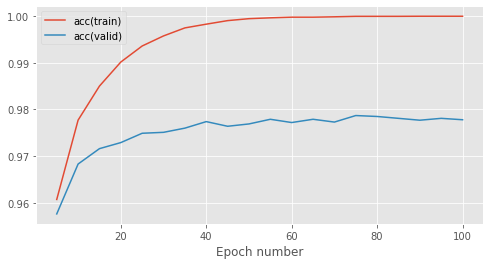

    final error(train) = 2.825e-03
    final error(valid) = 9.281e-02
    final acc(train)   = 1.000e+00
    final acc(valid)   = 9.778e-01
    run time per epoch = 0.945
-----------------------------------------------------------------------------------------------------------------------------
 num_epochs=100 batch_size=100 learning_rate=0.200 initializer=UniformInit(-0.050, 0.050) hidden_dim=150 n_hidden_layers=1
 regularizer=None regularizer_lambda=1
-----------------------------------------------------------------------------------------------------------------------------
MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=150)
    ReluLayer
    AffineLayer(input_dim=150, output_dim=10)
)


Experiment Progress: 100%|██████████| 100/100 [01:33<00:00,  1.07it/s]


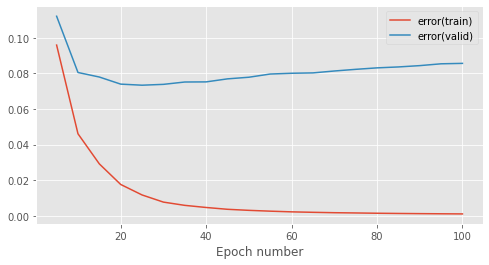

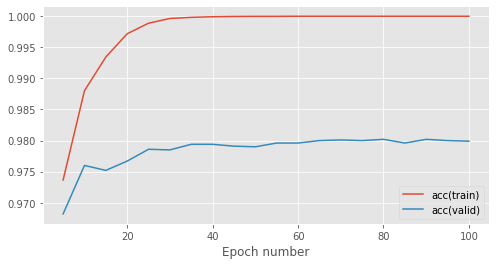

    final error(train) = 1.010e-03
    final error(valid) = 8.562e-02
    final acc(train)   = 1.000e+00
    final acc(valid)   = 9.799e-01
    run time per epoch = 0.940
-----------------------------------------------------------------------------------------------------------------------------
 num_epochs=100 batch_size=100 learning_rate=0.200 initializer=UniformInit(-0.100, 0.100) hidden_dim=150 n_hidden_layers=1
 regularizer=None regularizer_lambda=1
-----------------------------------------------------------------------------------------------------------------------------
MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=150)
    ReluLayer
    AffineLayer(input_dim=150, output_dim=10)
)


Experiment Progress: 100%|██████████| 100/100 [01:34<00:00,  1.06it/s]


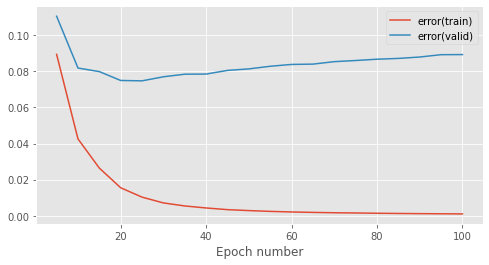

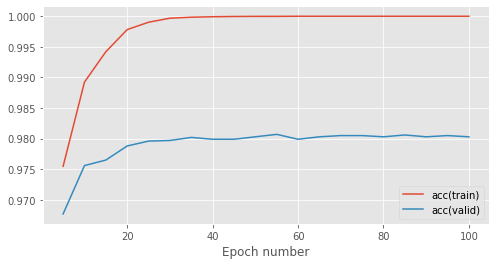

    final error(train) = 9.742e-04
    final error(valid) = 8.932e-02
    final acc(train)   = 1.000e+00
    final acc(valid)   = 9.803e-01
    run time per epoch = 0.950
-----------------------------------------------------------------------------------------------------------------------------
 num_epochs=100 batch_size=100 learning_rate=0.200 initializer=UniformInit(-0.200, 0.200) hidden_dim=150 n_hidden_layers=1
 regularizer=None regularizer_lambda=1
-----------------------------------------------------------------------------------------------------------------------------
MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=150)
    ReluLayer
    AffineLayer(input_dim=150, output_dim=10)
)


Experiment Progress: 100%|██████████| 100/100 [01:34<00:00,  1.06it/s]


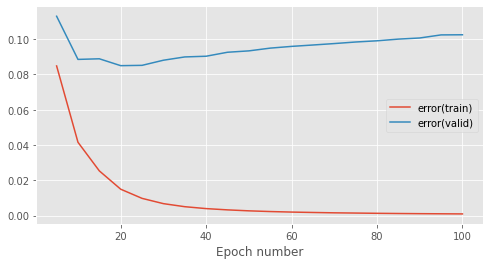

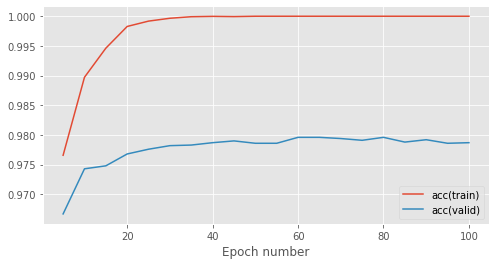

    final error(train) = 9.694e-04
    final error(valid) = 1.024e-01
    final acc(train)   = 1.000e+00
    final acc(valid)   = 9.787e-01
    run time per epoch = 0.949
-----------------------------------------------------------------------------------------------------------------------------
 num_epochs=100 batch_size=100 learning_rate=0.300 initializer=UniformInit(-0.050, 0.050) hidden_dim=150 n_hidden_layers=1
 regularizer=None regularizer_lambda=1
-----------------------------------------------------------------------------------------------------------------------------
MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=150)
    ReluLayer
    AffineLayer(input_dim=150, output_dim=10)
)


Experiment Progress: 100%|██████████| 100/100 [01:34<00:00,  1.06it/s]


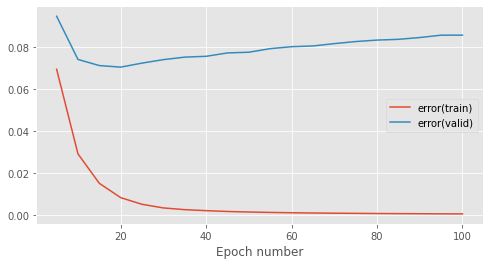

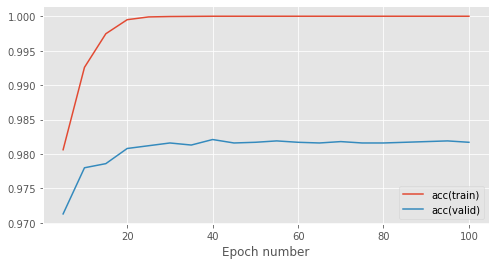

    final error(train) = 5.513e-04
    final error(valid) = 8.569e-02
    final acc(train)   = 1.000e+00
    final acc(valid)   = 9.817e-01
    run time per epoch = 0.946
-----------------------------------------------------------------------------------------------------------------------------
 num_epochs=100 batch_size=100 learning_rate=0.300 initializer=UniformInit(-0.100, 0.100) hidden_dim=150 n_hidden_layers=1
 regularizer=None regularizer_lambda=1
-----------------------------------------------------------------------------------------------------------------------------
MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=150)
    ReluLayer
    AffineLayer(input_dim=150, output_dim=10)
)


Experiment Progress: 100%|██████████| 100/100 [01:34<00:00,  1.06it/s]


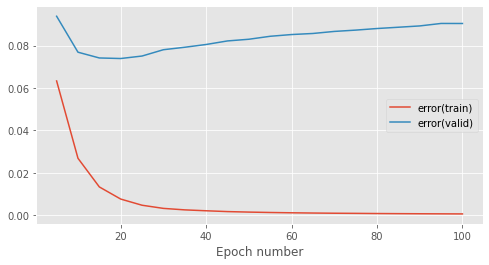

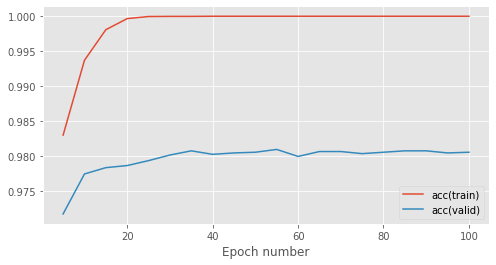

    final error(train) = 5.393e-04
    final error(valid) = 9.043e-02
    final acc(train)   = 1.000e+00
    final acc(valid)   = 9.806e-01
    run time per epoch = 0.948
-----------------------------------------------------------------------------------------------------------------------------
 num_epochs=100 batch_size=100 learning_rate=0.300 initializer=UniformInit(-0.200, 0.200) hidden_dim=150 n_hidden_layers=1
 regularizer=None regularizer_lambda=1
-----------------------------------------------------------------------------------------------------------------------------
MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=150)
    ReluLayer
    AffineLayer(input_dim=150, output_dim=10)
)


Experiment Progress: 100%|██████████| 100/100 [47:22<00:00, 28.43s/it]  


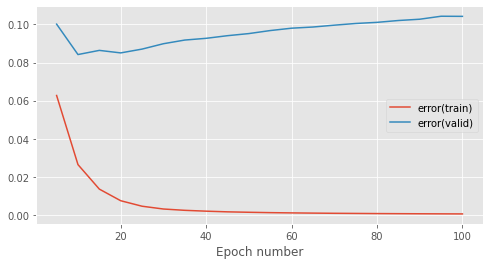

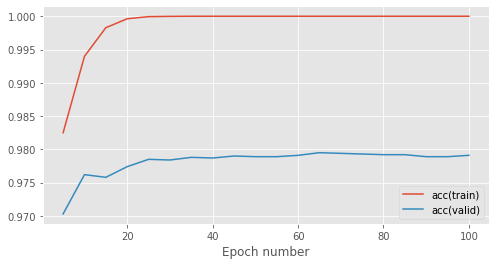

    final error(train) = 5.471e-04
    final error(valid) = 1.042e-01
    final acc(train)   = 1.000e+00
    final acc(valid)   = 9.791e-01
    run time per epoch = 28.430
-----------------------------------------------------------------------------------------------------------------------------
 num_epochs=100 batch_size=100 learning_rate=0.100 initializer=UniformInit(-0.050, 0.050) hidden_dim=300 n_hidden_layers=1
 regularizer=None regularizer_lambda=1
-----------------------------------------------------------------------------------------------------------------------------
MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=300)
    ReluLayer
    AffineLayer(input_dim=300, output_dim=10)
)


Experiment Progress: 100%|██████████| 100/100 [04:52<00:00,  2.93s/it]


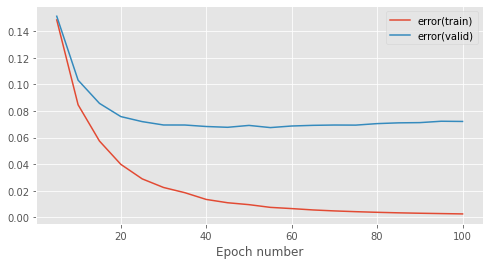

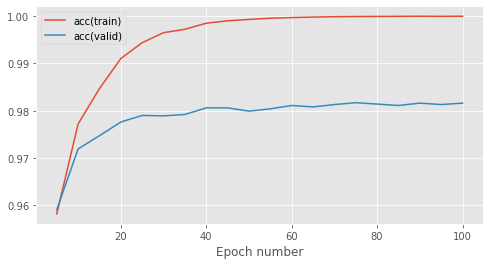

    final error(train) = 2.634e-03
    final error(valid) = 7.213e-02
    final acc(train)   = 1.000e+00
    final acc(valid)   = 9.816e-01
    run time per epoch = 2.936
-----------------------------------------------------------------------------------------------------------------------------
 num_epochs=100 batch_size=100 learning_rate=0.100 initializer=UniformInit(-0.100, 0.100) hidden_dim=300 n_hidden_layers=1
 regularizer=None regularizer_lambda=1
-----------------------------------------------------------------------------------------------------------------------------
MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=300)
    ReluLayer
    AffineLayer(input_dim=300, output_dim=10)
)


Experiment Progress: 100%|██████████| 100/100 [04:52<00:00,  2.93s/it]


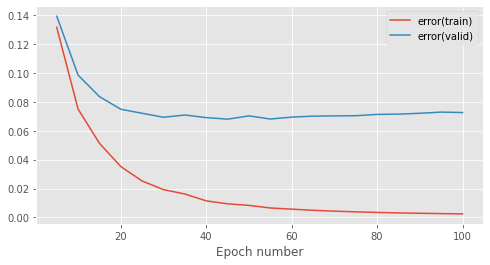

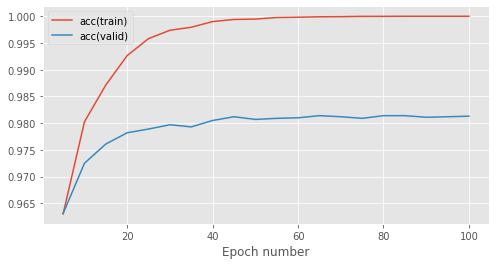

    final error(train) = 2.404e-03
    final error(valid) = 7.261e-02
    final acc(train)   = 1.000e+00
    final acc(valid)   = 9.813e-01
    run time per epoch = 2.941
-----------------------------------------------------------------------------------------------------------------------------
 num_epochs=100 batch_size=100 learning_rate=0.100 initializer=UniformInit(-0.200, 0.200) hidden_dim=300 n_hidden_layers=1
 regularizer=None regularizer_lambda=1
-----------------------------------------------------------------------------------------------------------------------------
MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=300)
    ReluLayer
    AffineLayer(input_dim=300, output_dim=10)
)


Experiment Progress: 100%|██████████| 100/100 [04:51<00:00,  2.91s/it]


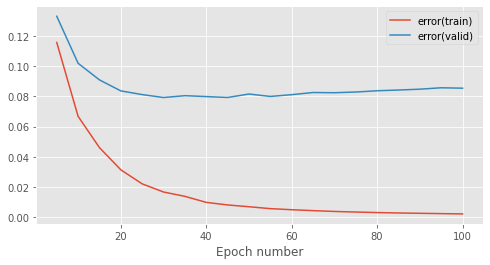

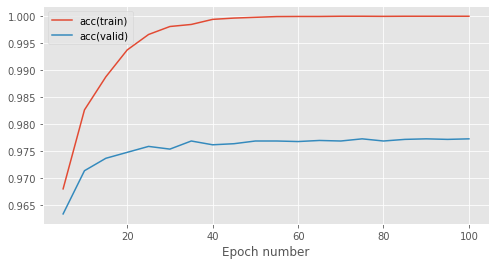

    final error(train) = 2.224e-03
    final error(valid) = 8.533e-02
    final acc(train)   = 1.000e+00
    final acc(valid)   = 9.773e-01
    run time per epoch = 2.924
-----------------------------------------------------------------------------------------------------------------------------
 num_epochs=100 batch_size=100 learning_rate=0.200 initializer=UniformInit(-0.050, 0.050) hidden_dim=300 n_hidden_layers=1
 regularizer=None regularizer_lambda=1
-----------------------------------------------------------------------------------------------------------------------------
MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=300)
    ReluLayer
    AffineLayer(input_dim=300, output_dim=10)
)


Experiment Progress: 100%|██████████| 100/100 [04:54<00:00,  2.95s/it]


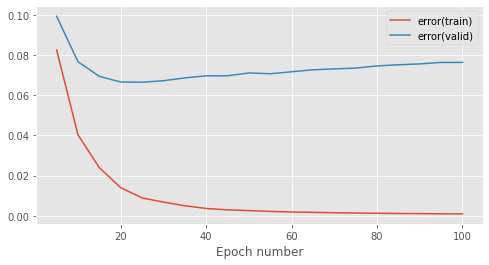

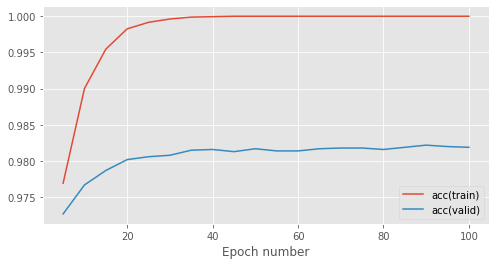

    final error(train) = 8.842e-04
    final error(valid) = 7.639e-02
    final acc(train)   = 1.000e+00
    final acc(valid)   = 9.819e-01
    run time per epoch = 2.959
-----------------------------------------------------------------------------------------------------------------------------
 num_epochs=100 batch_size=100 learning_rate=0.200 initializer=UniformInit(-0.100, 0.100) hidden_dim=300 n_hidden_layers=1
 regularizer=None regularizer_lambda=1
-----------------------------------------------------------------------------------------------------------------------------
MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=300)
    ReluLayer
    AffineLayer(input_dim=300, output_dim=10)
)


Experiment Progress: 100%|██████████| 100/100 [04:54<00:00,  2.94s/it]


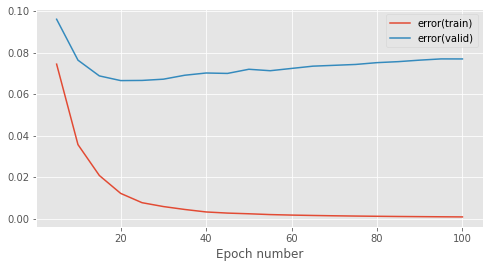

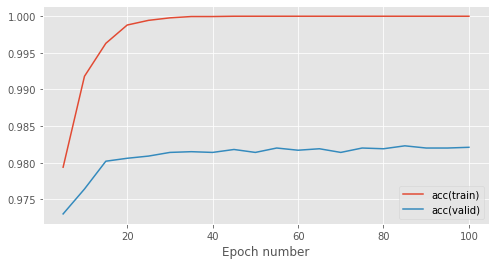

    final error(train) = 8.465e-04
    final error(valid) = 7.692e-02
    final acc(train)   = 1.000e+00
    final acc(valid)   = 9.821e-01
    run time per epoch = 2.952
-----------------------------------------------------------------------------------------------------------------------------
 num_epochs=100 batch_size=100 learning_rate=0.200 initializer=UniformInit(-0.200, 0.200) hidden_dim=300 n_hidden_layers=1
 regularizer=None regularizer_lambda=1
-----------------------------------------------------------------------------------------------------------------------------
MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=300)
    ReluLayer
    AffineLayer(input_dim=300, output_dim=10)
)


Experiment Progress: 100%|██████████| 100/100 [04:55<00:00,  2.96s/it]


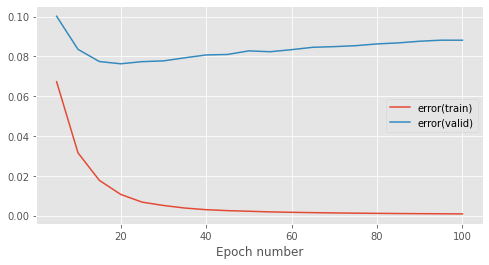

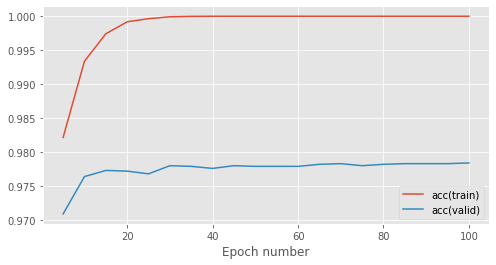

    final error(train) = 8.142e-04
    final error(valid) = 8.815e-02
    final acc(train)   = 1.000e+00
    final acc(valid)   = 9.784e-01
    run time per epoch = 2.971
-----------------------------------------------------------------------------------------------------------------------------
 num_epochs=100 batch_size=100 learning_rate=0.300 initializer=UniformInit(-0.050, 0.050) hidden_dim=300 n_hidden_layers=1
 regularizer=None regularizer_lambda=1
-----------------------------------------------------------------------------------------------------------------------------
MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=300)
    ReluLayer
    AffineLayer(input_dim=300, output_dim=10)
)


Experiment Progress: 100%|██████████| 100/100 [04:54<00:00,  2.95s/it]


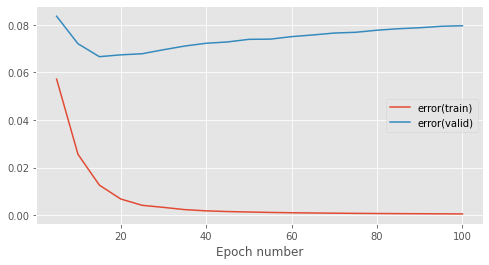

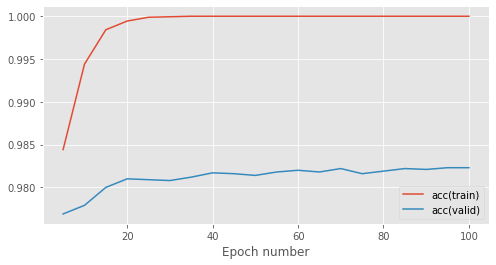

    final error(train) = 5.003e-04
    final error(valid) = 7.967e-02
    final acc(train)   = 1.000e+00
    final acc(valid)   = 9.823e-01
    run time per epoch = 2.960
-----------------------------------------------------------------------------------------------------------------------------
 num_epochs=100 batch_size=100 learning_rate=0.300 initializer=UniformInit(-0.100, 0.100) hidden_dim=300 n_hidden_layers=1
 regularizer=None regularizer_lambda=1
-----------------------------------------------------------------------------------------------------------------------------
MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=300)
    ReluLayer
    AffineLayer(input_dim=300, output_dim=10)
)


Experiment Progress: 100%|██████████| 100/100 [04:56<00:00,  2.96s/it]


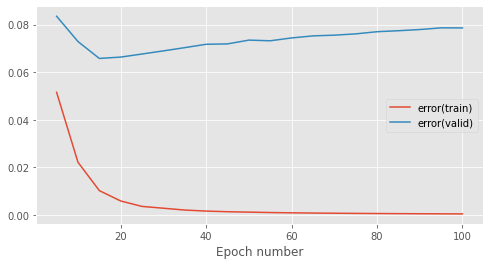

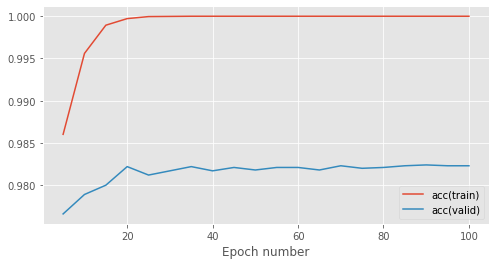

    final error(train) = 4.850e-04
    final error(valid) = 7.862e-02
    final acc(train)   = 1.000e+00
    final acc(valid)   = 9.823e-01
    run time per epoch = 2.977
-----------------------------------------------------------------------------------------------------------------------------
 num_epochs=100 batch_size=100 learning_rate=0.300 initializer=UniformInit(-0.200, 0.200) hidden_dim=300 n_hidden_layers=1
 regularizer=None regularizer_lambda=1
-----------------------------------------------------------------------------------------------------------------------------
MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=300)
    ReluLayer
    AffineLayer(input_dim=300, output_dim=10)
)


Experiment Progress: 100%|██████████| 100/100 [06:08<00:00,  3.69s/it]


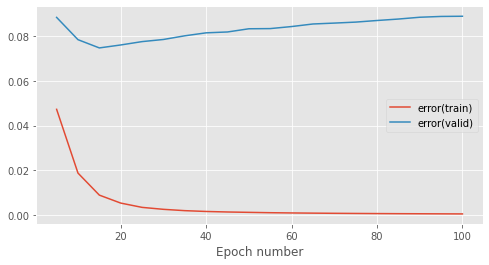

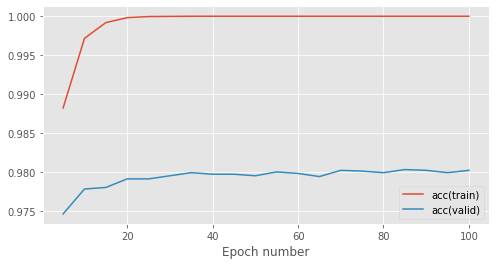

    final error(train) = 4.749e-04
    final error(valid) = 8.899e-02
    final acc(train)   = 1.000e+00
    final acc(valid)   = 9.802e-01
    run time per epoch = 3.700
-----------------------------------------------------------------------------------------------------------------------------
 num_epochs=100 batch_size=100 learning_rate=0.100 initializer=UniformInit(-0.050, 0.050) hidden_dim=150 n_hidden_layers=2
 regularizer=None regularizer_lambda=1
-----------------------------------------------------------------------------------------------------------------------------
MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=150)
    ReluLayer
    AffineLayer(input_dim=150, output_dim=75)
    ReluLayer
    AffineLayer(input_dim=75, output_dim=10)
)


Experiment Progress: 100%|██████████| 100/100 [02:05<00:00,  1.26s/it]


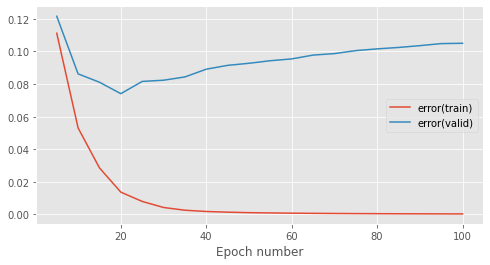

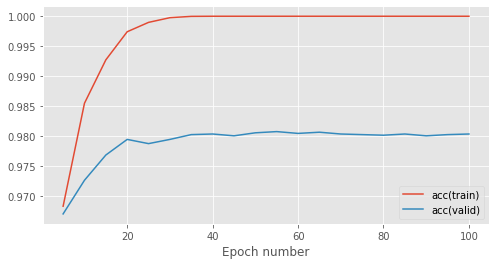

    final error(train) = 3.527e-04
    final error(valid) = 1.050e-01
    final acc(train)   = 1.000e+00
    final acc(valid)   = 9.804e-01
    run time per epoch = 1.268
-----------------------------------------------------------------------------------------------------------------------------
 num_epochs=100 batch_size=100 learning_rate=0.100 initializer=UniformInit(-0.100, 0.100) hidden_dim=150 n_hidden_layers=2
 regularizer=None regularizer_lambda=1
-----------------------------------------------------------------------------------------------------------------------------
MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=150)
    ReluLayer
    AffineLayer(input_dim=150, output_dim=75)
    ReluLayer
    AffineLayer(input_dim=75, output_dim=10)
)


Experiment Progress: 100%|██████████| 100/100 [01:49<00:00,  1.09s/it]


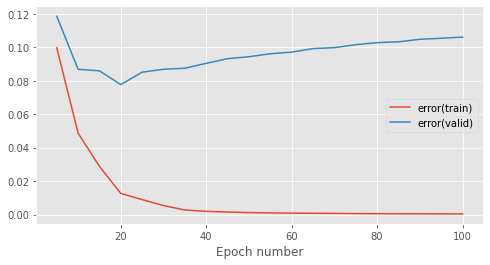

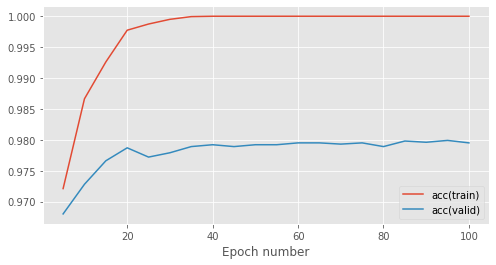

    final error(train) = 3.639e-04
    final error(valid) = 1.061e-01
    final acc(train)   = 1.000e+00
    final acc(valid)   = 9.795e-01
    run time per epoch = 1.098
-----------------------------------------------------------------------------------------------------------------------------
 num_epochs=100 batch_size=100 learning_rate=0.100 initializer=UniformInit(-0.200, 0.200) hidden_dim=150 n_hidden_layers=2
 regularizer=None regularizer_lambda=1
-----------------------------------------------------------------------------------------------------------------------------
MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=150)
    ReluLayer
    AffineLayer(input_dim=150, output_dim=75)
    ReluLayer
    AffineLayer(input_dim=75, output_dim=10)
)


Experiment Progress: 100%|██████████| 100/100 [01:49<00:00,  1.09s/it]


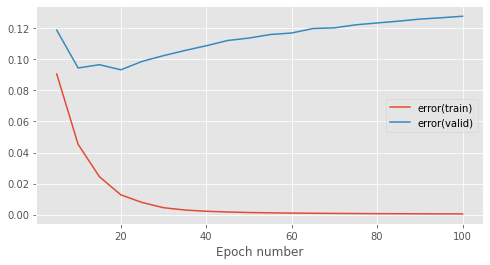

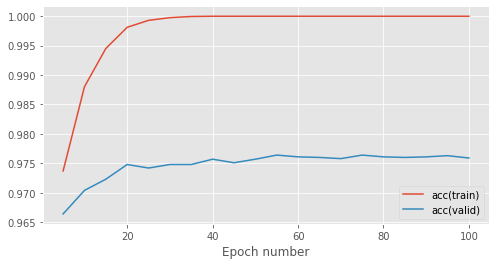

    final error(train) = 4.216e-04
    final error(valid) = 1.279e-01
    final acc(train)   = 1.000e+00
    final acc(valid)   = 9.759e-01
    run time per epoch = 1.098
-----------------------------------------------------------------------------------------------------------------------------
 num_epochs=100 batch_size=100 learning_rate=0.200 initializer=UniformInit(-0.050, 0.050) hidden_dim=150 n_hidden_layers=2
 regularizer=None regularizer_lambda=1
-----------------------------------------------------------------------------------------------------------------------------
MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=150)
    ReluLayer
    AffineLayer(input_dim=150, output_dim=75)
    ReluLayer
    AffineLayer(input_dim=75, output_dim=10)
)


Experiment Progress: 100%|██████████| 100/100 [01:46<00:00,  1.07s/it]


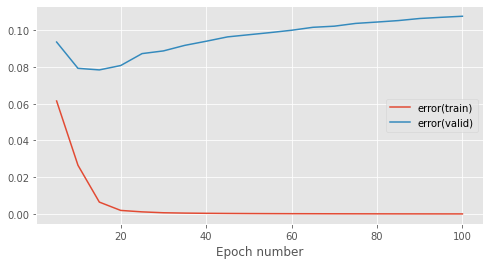

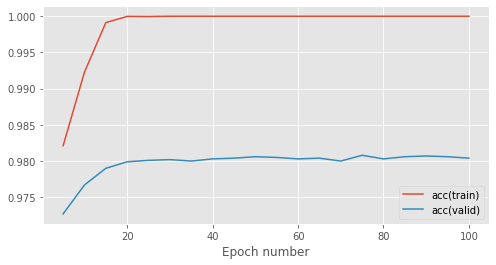

    final error(train) = 1.231e-04
    final error(valid) = 1.075e-01
    final acc(train)   = 1.000e+00
    final acc(valid)   = 9.804e-01
    run time per epoch = 1.074
-----------------------------------------------------------------------------------------------------------------------------
 num_epochs=100 batch_size=100 learning_rate=0.200 initializer=UniformInit(-0.100, 0.100) hidden_dim=150 n_hidden_layers=2
 regularizer=None regularizer_lambda=1
-----------------------------------------------------------------------------------------------------------------------------
MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=150)
    ReluLayer
    AffineLayer(input_dim=150, output_dim=75)
    ReluLayer
    AffineLayer(input_dim=75, output_dim=10)
)


Experiment Progress: 100%|██████████| 100/100 [01:48<00:00,  1.09s/it]


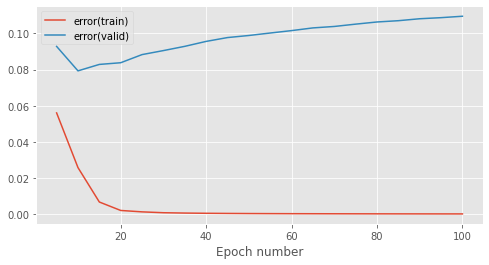

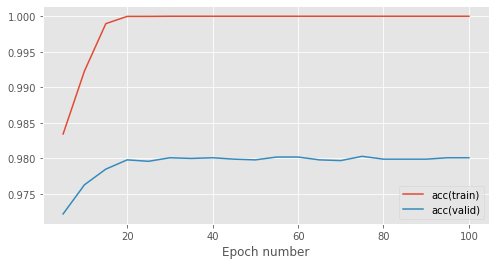

    final error(train) = 1.287e-04
    final error(valid) = 1.095e-01
    final acc(train)   = 1.000e+00
    final acc(valid)   = 9.801e-01
    run time per epoch = 1.090
-----------------------------------------------------------------------------------------------------------------------------
 num_epochs=100 batch_size=100 learning_rate=0.200 initializer=UniformInit(-0.200, 0.200) hidden_dim=150 n_hidden_layers=2
 regularizer=None regularizer_lambda=1
-----------------------------------------------------------------------------------------------------------------------------
MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=150)
    ReluLayer
    AffineLayer(input_dim=150, output_dim=75)
    ReluLayer
    AffineLayer(input_dim=75, output_dim=10)
)


Experiment Progress: 100%|██████████| 100/100 [01:47<00:00,  1.08s/it]


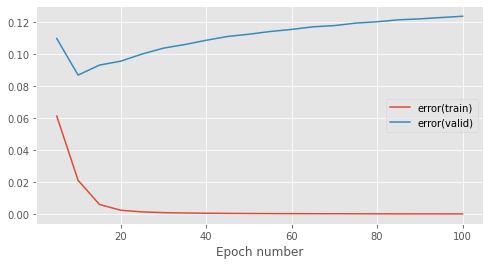

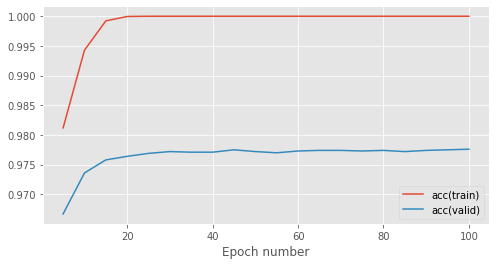

    final error(train) = 1.583e-04
    final error(valid) = 1.236e-01
    final acc(train)   = 1.000e+00
    final acc(valid)   = 9.776e-01
    run time per epoch = 1.082
-----------------------------------------------------------------------------------------------------------------------------
 num_epochs=100 batch_size=100 learning_rate=0.300 initializer=UniformInit(-0.050, 0.050) hidden_dim=150 n_hidden_layers=2
 regularizer=None regularizer_lambda=1
-----------------------------------------------------------------------------------------------------------------------------
MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=150)
    ReluLayer
    AffineLayer(input_dim=150, output_dim=75)
    ReluLayer
    AffineLayer(input_dim=75, output_dim=10)
)


Experiment Progress: 100%|██████████| 100/100 [01:48<00:00,  1.08s/it]


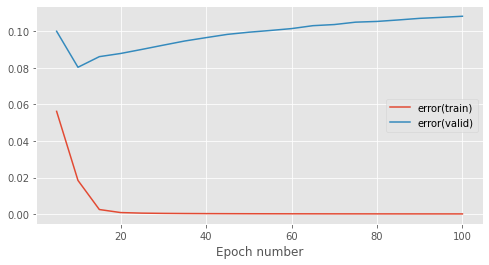

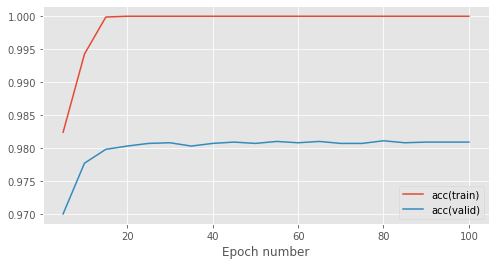

    final error(train) = 6.952e-05
    final error(valid) = 1.083e-01
    final acc(train)   = 1.000e+00
    final acc(valid)   = 9.809e-01
    run time per epoch = 1.086
-----------------------------------------------------------------------------------------------------------------------------
 num_epochs=100 batch_size=100 learning_rate=0.300 initializer=UniformInit(-0.100, 0.100) hidden_dim=150 n_hidden_layers=2
 regularizer=None regularizer_lambda=1
-----------------------------------------------------------------------------------------------------------------------------
MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=150)
    ReluLayer
    AffineLayer(input_dim=150, output_dim=75)
    ReluLayer
    AffineLayer(input_dim=75, output_dim=10)
)


Experiment Progress: 100%|██████████| 100/100 [01:47<00:00,  1.07s/it]


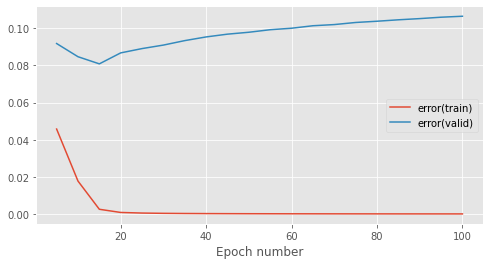

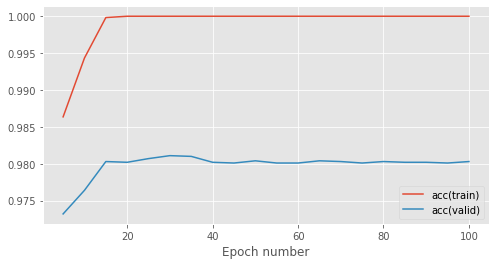

    final error(train) = 7.419e-05
    final error(valid) = 1.064e-01
    final acc(train)   = 1.000e+00
    final acc(valid)   = 9.803e-01
    run time per epoch = 1.079
-----------------------------------------------------------------------------------------------------------------------------
 num_epochs=100 batch_size=100 learning_rate=0.300 initializer=UniformInit(-0.200, 0.200) hidden_dim=150 n_hidden_layers=2
 regularizer=None regularizer_lambda=1
-----------------------------------------------------------------------------------------------------------------------------
MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=150)
    ReluLayer
    AffineLayer(input_dim=150, output_dim=75)
    ReluLayer
    AffineLayer(input_dim=75, output_dim=10)
)


Experiment Progress: 100%|██████████| 100/100 [01:48<00:00,  1.08s/it]


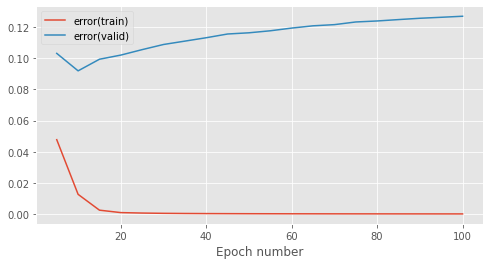

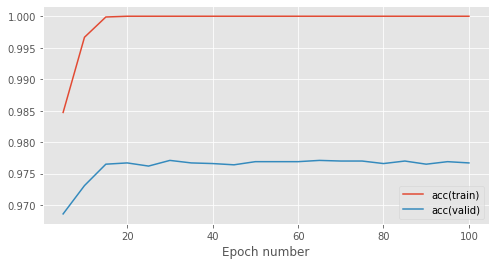

    final error(train) = 9.060e-05
    final error(valid) = 1.270e-01
    final acc(train)   = 1.000e+00
    final acc(valid)   = 9.767e-01
    run time per epoch = 1.086
-----------------------------------------------------------------------------------------------------------------------------
 num_epochs=100 batch_size=100 learning_rate=0.100 initializer=UniformInit(-0.050, 0.050) hidden_dim=300 n_hidden_layers=2
 regularizer=None regularizer_lambda=1
-----------------------------------------------------------------------------------------------------------------------------
MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=300)
    ReluLayer
    AffineLayer(input_dim=300, output_dim=150)
    ReluLayer
    AffineLayer(input_dim=150, output_dim=10)
)


Experiment Progress: 100%|██████████| 100/100 [03:03<00:00,  1.84s/it]


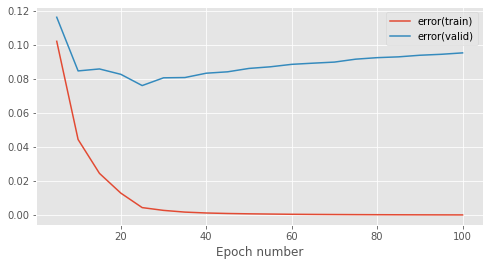

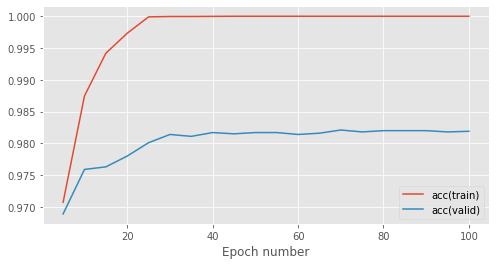

    final error(train) = 3.115e-04
    final error(valid) = 9.550e-02
    final acc(train)   = 1.000e+00
    final acc(valid)   = 9.819e-01
    run time per epoch = 1.842
-----------------------------------------------------------------------------------------------------------------------------
 num_epochs=100 batch_size=100 learning_rate=0.100 initializer=UniformInit(-0.100, 0.100) hidden_dim=300 n_hidden_layers=2
 regularizer=None regularizer_lambda=1
-----------------------------------------------------------------------------------------------------------------------------
MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=300)
    ReluLayer
    AffineLayer(input_dim=300, output_dim=150)
    ReluLayer
    AffineLayer(input_dim=150, output_dim=10)
)


Experiment Progress: 100%|██████████| 100/100 [03:04<00:00,  1.84s/it]


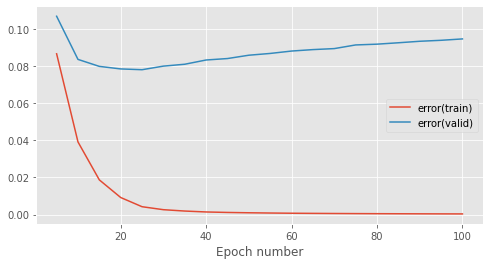

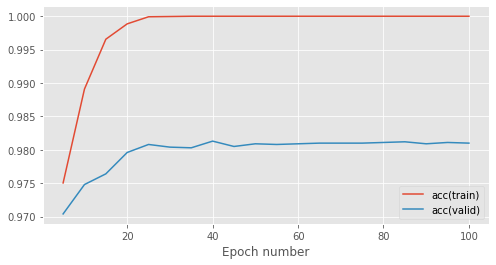

    final error(train) = 3.160e-04
    final error(valid) = 9.474e-02
    final acc(train)   = 1.000e+00
    final acc(valid)   = 9.810e-01
    run time per epoch = 1.852
-----------------------------------------------------------------------------------------------------------------------------
 num_epochs=100 batch_size=100 learning_rate=0.100 initializer=UniformInit(-0.200, 0.200) hidden_dim=300 n_hidden_layers=2
 regularizer=None regularizer_lambda=1
-----------------------------------------------------------------------------------------------------------------------------
MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=300)
    ReluLayer
    AffineLayer(input_dim=300, output_dim=150)
    ReluLayer
    AffineLayer(input_dim=150, output_dim=10)
)


Experiment Progress: 100%|██████████| 100/100 [03:04<00:00,  1.85s/it]


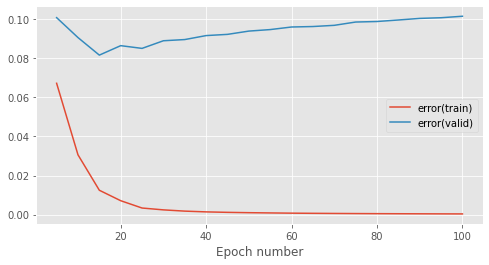

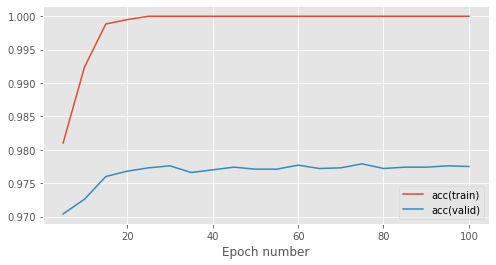

    final error(train) = 3.607e-04
    final error(valid) = 1.015e-01
    final acc(train)   = 1.000e+00
    final acc(valid)   = 9.775e-01
    run time per epoch = 1.856
-----------------------------------------------------------------------------------------------------------------------------
 num_epochs=100 batch_size=100 learning_rate=0.200 initializer=UniformInit(-0.050, 0.050) hidden_dim=300 n_hidden_layers=2
 regularizer=None regularizer_lambda=1
-----------------------------------------------------------------------------------------------------------------------------
MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=300)
    ReluLayer
    AffineLayer(input_dim=300, output_dim=150)
    ReluLayer
    AffineLayer(input_dim=150, output_dim=10)
)


Experiment Progress: 100%|██████████| 100/100 [03:04<00:00,  1.84s/it]


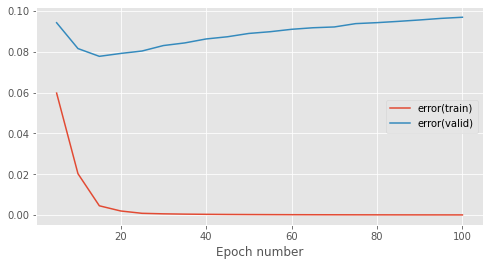

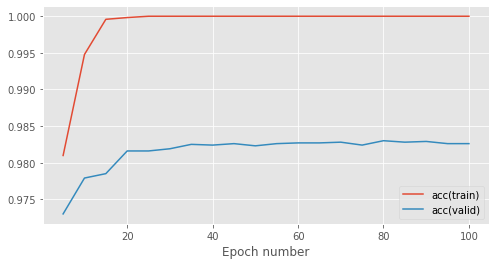

    final error(train) = 1.138e-04
    final error(valid) = 9.688e-02
    final acc(train)   = 1.000e+00
    final acc(valid)   = 9.826e-01
    run time per epoch = 1.851
-----------------------------------------------------------------------------------------------------------------------------
 num_epochs=100 batch_size=100 learning_rate=0.200 initializer=UniformInit(-0.100, 0.100) hidden_dim=300 n_hidden_layers=2
 regularizer=None regularizer_lambda=1
-----------------------------------------------------------------------------------------------------------------------------
MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=300)
    ReluLayer
    AffineLayer(input_dim=300, output_dim=150)
    ReluLayer
    AffineLayer(input_dim=150, output_dim=10)
)


Experiment Progress: 100%|██████████| 100/100 [03:04<00:00,  1.84s/it]


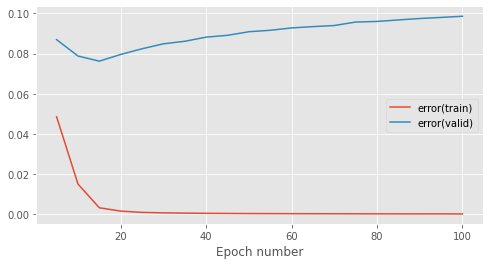

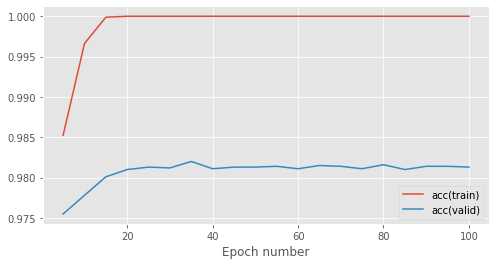

    final error(train) = 1.185e-04
    final error(valid) = 9.858e-02
    final acc(train)   = 1.000e+00
    final acc(valid)   = 9.813e-01
    run time per epoch = 1.851
-----------------------------------------------------------------------------------------------------------------------------
 num_epochs=100 batch_size=100 learning_rate=0.200 initializer=UniformInit(-0.200, 0.200) hidden_dim=300 n_hidden_layers=2
 regularizer=None regularizer_lambda=1
-----------------------------------------------------------------------------------------------------------------------------
MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=300)
    ReluLayer
    AffineLayer(input_dim=300, output_dim=150)
    ReluLayer
    AffineLayer(input_dim=150, output_dim=10)
)


Experiment Progress: 100%|██████████| 100/100 [03:05<00:00,  1.85s/it]


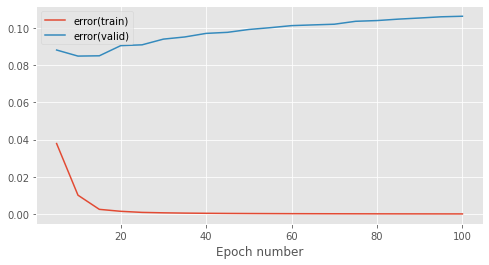

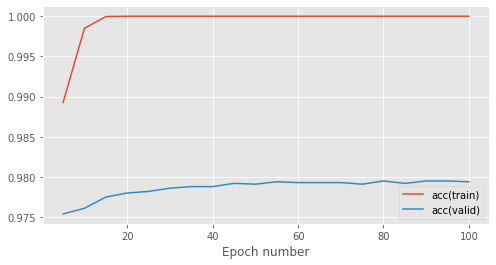

    final error(train) = 1.449e-04
    final error(valid) = 1.062e-01
    final acc(train)   = 1.000e+00
    final acc(valid)   = 9.794e-01
    run time per epoch = 1.860
-----------------------------------------------------------------------------------------------------------------------------
 num_epochs=100 batch_size=100 learning_rate=0.300 initializer=UniformInit(-0.050, 0.050) hidden_dim=300 n_hidden_layers=2
 regularizer=None regularizer_lambda=1
-----------------------------------------------------------------------------------------------------------------------------
MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=300)
    ReluLayer
    AffineLayer(input_dim=300, output_dim=150)
    ReluLayer
    AffineLayer(input_dim=150, output_dim=10)
)


Experiment Progress: 100%|██████████| 100/100 [03:04<00:00,  1.84s/it]


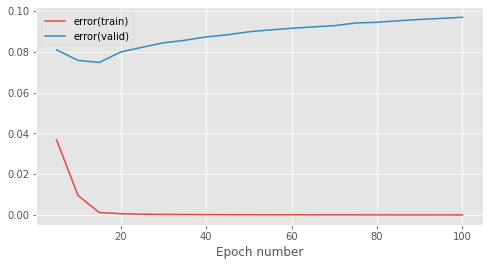

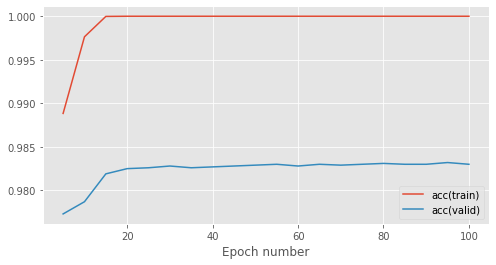

    final error(train) = 6.472e-05
    final error(valid) = 9.701e-02
    final acc(train)   = 1.000e+00
    final acc(valid)   = 9.830e-01
    run time per epoch = 1.849
-----------------------------------------------------------------------------------------------------------------------------
 num_epochs=100 batch_size=100 learning_rate=0.300 initializer=UniformInit(-0.100, 0.100) hidden_dim=300 n_hidden_layers=2
 regularizer=None regularizer_lambda=1
-----------------------------------------------------------------------------------------------------------------------------
MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=300)
    ReluLayer
    AffineLayer(input_dim=300, output_dim=150)
    ReluLayer
    AffineLayer(input_dim=150, output_dim=10)
)


Experiment Progress: 100%|██████████| 100/100 [03:04<00:00,  1.84s/it]


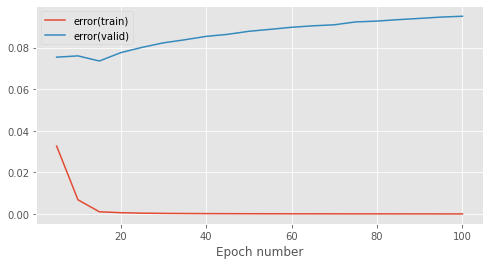

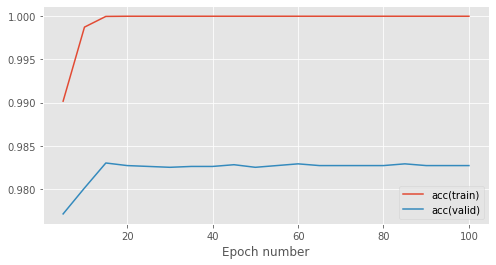

    final error(train) = 6.824e-05
    final error(valid) = 9.509e-02
    final acc(train)   = 1.000e+00
    final acc(valid)   = 9.827e-01
    run time per epoch = 1.852
-----------------------------------------------------------------------------------------------------------------------------
 num_epochs=100 batch_size=100 learning_rate=0.300 initializer=UniformInit(-0.200, 0.200) hidden_dim=300 n_hidden_layers=2
 regularizer=None regularizer_lambda=1
-----------------------------------------------------------------------------------------------------------------------------
MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=300)
    ReluLayer
    AffineLayer(input_dim=300, output_dim=150)
    ReluLayer
    AffineLayer(input_dim=150, output_dim=10)
)


Experiment Progress: 100%|██████████| 100/100 [03:04<00:00,  1.85s/it]


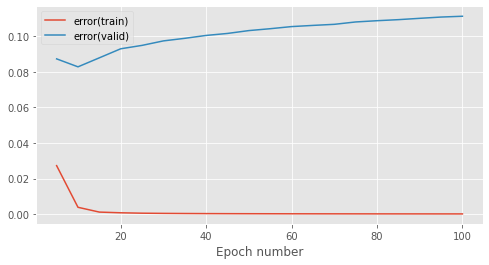

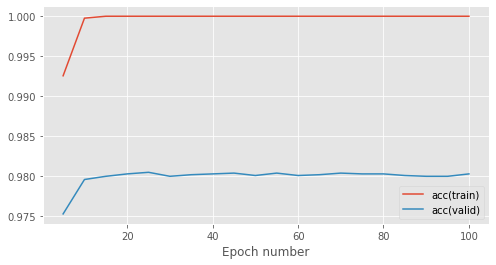

    final error(train) = 8.464e-05
    final error(valid) = 1.113e-01
    final acc(train)   = 1.000e+00
    final acc(valid)   = 9.803e-01
    run time per epoch = 1.853


In [75]:
run_grid(learning_rates=[0.1, 0.2, 0.3],
         initializers=[UniformInit(-init_scale, init_scale) for init_scale in (0.05, 0.1, 0.2)],
         hidden_dims=[150, 300],
         n_hidden_layers=[1, 2])
# Choose learning_rate=0.3, initial scale=0.05, hidden layer dimension: 300, 1 hidden layers

## 1 Baseline Network
The hyper-parameters that were explored for the baseline model are the _learning rate_, the _initialization scale range_, the _number of hidden layers_, and the _hidden layer dimension_.

I varied the hyper-parameters to get a feeling about the effects on the accuracy, and finally did a grid search in the region around a reasonable hyper-parameter set to get a better idea about an optimal parameter choice.

I did not increase the hidden layer dimension to over 300 to save computation time.

Here's my baseline model choice that leads to an accuracy of __98.30%__:
* Affine $\xrightarrow{}$ RELU $\xrightarrow{}$ Affine $\xrightarrow{}$ Softmax $\xrightarrow{}$ Cross-Entropy
* _Learning rate_: 0.3
* _Uniform initialization scale range_: 0.05
* _Hidden layer dimension_: 300 + 150
* _Number of hidden layers_: 2

-----------------------------------------------------------------------------------------------------------------------------
 num_epochs=100 batch_size=100 learning_rate=0.300 initializer=UniformInit(-0.050, 0.050) hidden_dim=300 n_hidden_layers=2
 regularizer=None regularizer_lambda=1
-----------------------------------------------------------------------------------------------------------------------------
MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=300)
    ReluLayer
    AffineLayer(input_dim=300, output_dim=150)
    ReluLayer
    AffineLayer(input_dim=150, output_dim=10)
)


Experiment Progress: 100%|██████████| 100/100 [04:01<00:00,  2.42s/it]


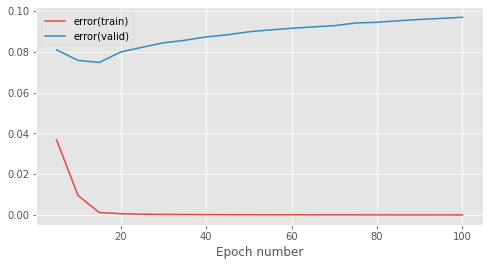

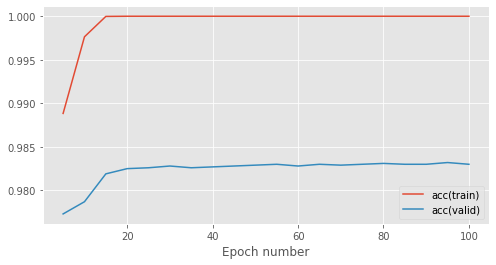

    final error(train) = 6.472e-05
    final error(valid) = 9.701e-02
    final acc(train)   = 1.000e+00
    final acc(valid)   = 9.830e-01
    run time per epoch = 2.424


MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=300)
    ReluLayer
    AffineLayer(input_dim=300, output_dim=150)
    ReluLayer
    AffineLayer(input_dim=150, output_dim=10)
)

In [33]:
run(learning_rate=0.3, initializer=UniformInit(-0.05, 0.05), hidden_dim=300, n_hidden_layers=2)

### Alternative activation functions
Run base model with different activation functions using their default parameters

-----------------------------------------------------------------------------------------------------------------------------
 num_epochs=100 batch_size=100 learning_rate=0.300 initializer=UniformInit(-0.050, 0.050) hidden_dim=300 n_hidden_layers=2
 regularizer=None regularizer_lambda=1
-----------------------------------------------------------------------------------------------------------------------------
MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=300)
    EluLayer(alpha=1.000)
    AffineLayer(input_dim=300, output_dim=150)
    EluLayer(alpha=1.000)
    AffineLayer(input_dim=150, output_dim=10)
)


Experiment Progress: 100%|██████████| 100/100 [05:20<00:00,  3.20s/it]


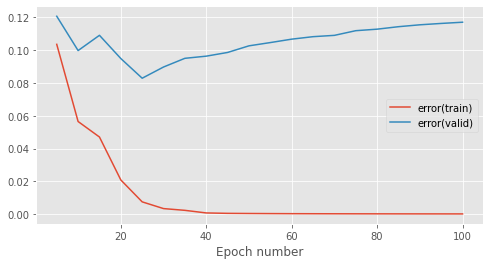

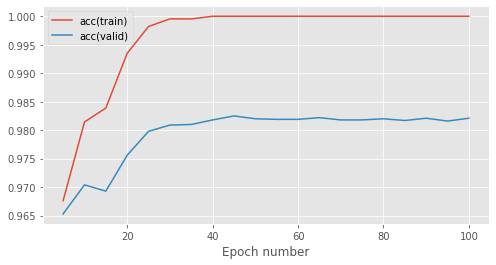

    final error(train) = 1.238e-04
    final error(valid) = 1.170e-01
    final acc(train)   = 1.000e+00
    final acc(valid)   = 9.821e-01
    run time per epoch = 3.217
-----------------------------------------------------------------------------------------------------------------------------
 num_epochs=100 batch_size=100 learning_rate=0.300 initializer=UniformInit(-0.050, 0.050) hidden_dim=300 n_hidden_layers=2
 regularizer=None regularizer_lambda=1
-----------------------------------------------------------------------------------------------------------------------------
MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=300)
    SeluLayer
    AffineLayer(input_dim=300, output_dim=150)
    SeluLayer
    AffineLayer(input_dim=150, output_dim=10)
)


Experiment Progress: 100%|██████████| 100/100 [05:22<00:00,  3.23s/it]


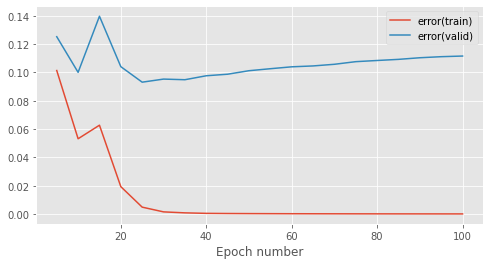

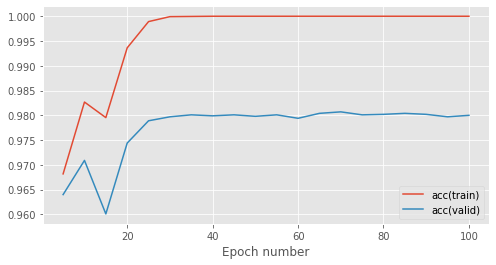

    final error(train) = 1.262e-04
    final error(valid) = 1.115e-01
    final acc(train)   = 1.000e+00
    final acc(valid)   = 9.800e-01
    run time per epoch = 3.242
-----------------------------------------------------------------------------------------------------------------------------
 num_epochs=100 batch_size=100 learning_rate=0.300 initializer=UniformInit(-0.050, 0.050) hidden_dim=300 n_hidden_layers=2
 regularizer=None regularizer_lambda=1
-----------------------------------------------------------------------------------------------------------------------------
MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=300)
    GeluLayer
    AffineLayer(input_dim=300, output_dim=150)
    GeluLayer
    AffineLayer(input_dim=150, output_dim=10)
)


Experiment Progress: 100%|██████████| 100/100 [05:26<00:00,  3.27s/it]


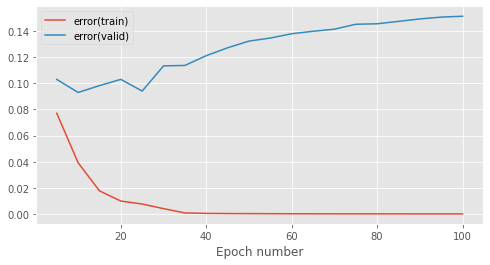

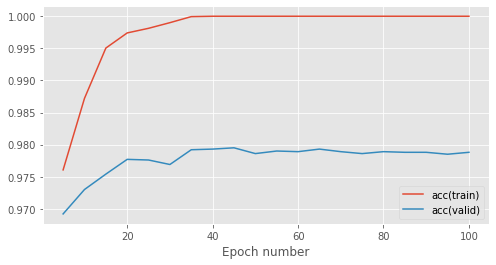

    final error(train) = 9.511e-05
    final error(valid) = 1.513e-01
    final acc(train)   = 1.000e+00
    final acc(valid)   = 9.788e-01
    run time per epoch = 3.282
-----------------------------------------------------------------------------------------------------------------------------
 num_epochs=100 batch_size=100 learning_rate=0.300 initializer=UniformInit(-0.050, 0.050) hidden_dim=300 n_hidden_layers=2
 regularizer=None regularizer_lambda=1
-----------------------------------------------------------------------------------------------------------------------------
MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=300)
    IsrluLayer(alpha=1.000)
    AffineLayer(input_dim=300, output_dim=150)
    IsrluLayer(alpha=1.000)
    AffineLayer(input_dim=150, output_dim=10)
)


Experiment Progress: 100%|██████████| 100/100 [06:28<00:00,  3.88s/it]


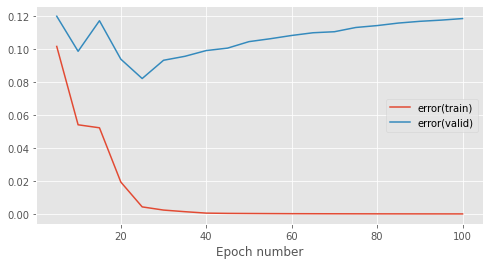

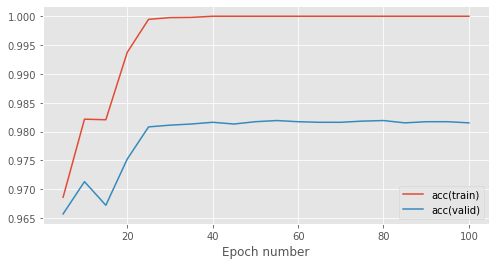

    final error(train) = 1.236e-04
    final error(valid) = 1.184e-01
    final acc(train)   = 1.000e+00
    final acc(valid)   = 9.815e-01
    run time per epoch = 3.900


In [35]:
run_grid(activation_layers=[EluLayer(),
                            SeluLayer(),
                            GeluLayer(),
                            IsrluLayer()],
         learning_rates=[0.3],
         initializers=[UniformInit(-0.05, 0.05)],
         hidden_dims=[300],
         n_hidden_layers=[2])
# Worse results than baseline model

### Parametrizable activation functions
Test different parameters for the parameterizable activation functions

-----------------------------------------------------------------------------------------------------------------------------
 num_epochs=100 batch_size=100 learning_rate=0.300 initializer=UniformInit(-0.050, 0.050) hidden_dim=300 n_hidden_layers=2
 regularizer=None regularizer_lambda=1
-----------------------------------------------------------------------------------------------------------------------------
MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=300)
    EluLayer(alpha=0.100)
    AffineLayer(input_dim=300, output_dim=150)
    EluLayer(alpha=0.100)
    AffineLayer(input_dim=150, output_dim=10)
)


Experiment Progress: 100%|██████████| 100/100 [04:57<00:00,  2.97s/it]


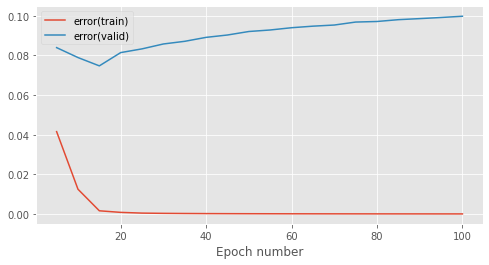

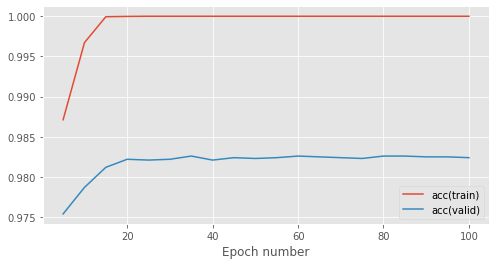

    final error(train) = 6.946e-05
    final error(valid) = 9.974e-02
    final acc(train)   = 1.000e+00
    final acc(valid)   = 9.824e-01
    run time per epoch = 2.987
-----------------------------------------------------------------------------------------------------------------------------
 num_epochs=100 batch_size=100 learning_rate=0.300 initializer=UniformInit(-0.050, 0.050) hidden_dim=300 n_hidden_layers=2
 regularizer=None regularizer_lambda=1
-----------------------------------------------------------------------------------------------------------------------------
MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=300)
    EluLayer(alpha=0.200)
    AffineLayer(input_dim=300, output_dim=150)
    EluLayer(alpha=0.200)
    AffineLayer(input_dim=150, output_dim=10)
)


Experiment Progress: 100%|██████████| 100/100 [05:17<00:00,  3.17s/it]


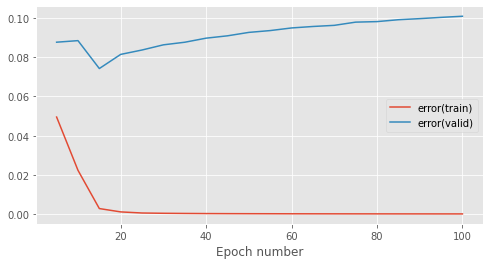

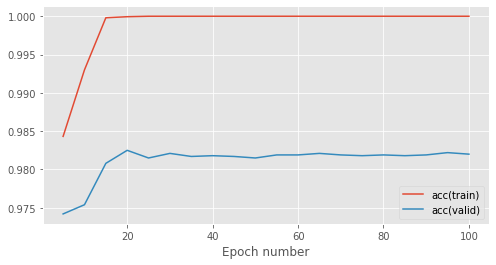

    final error(train) = 7.437e-05
    final error(valid) = 1.009e-01
    final acc(train)   = 1.000e+00
    final acc(valid)   = 9.820e-01
    run time per epoch = 3.186
-----------------------------------------------------------------------------------------------------------------------------
 num_epochs=100 batch_size=100 learning_rate=0.300 initializer=UniformInit(-0.050, 0.050) hidden_dim=300 n_hidden_layers=2
 regularizer=None regularizer_lambda=1
-----------------------------------------------------------------------------------------------------------------------------
MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=300)
    EluLayer(alpha=0.400)
    AffineLayer(input_dim=300, output_dim=150)
    EluLayer(alpha=0.400)
    AffineLayer(input_dim=150, output_dim=10)
)


Experiment Progress: 100%|██████████| 100/100 [05:06<00:00,  3.07s/it]


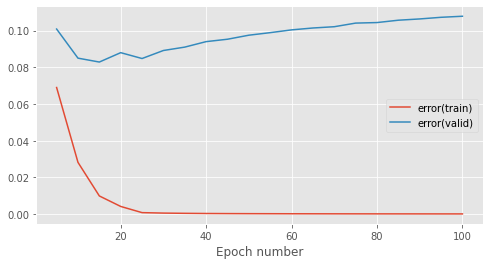

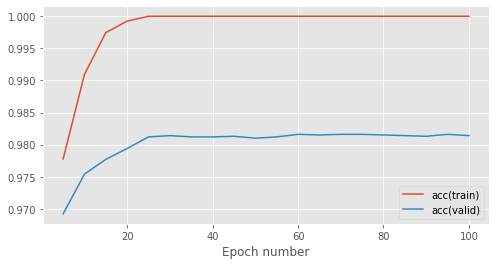

    final error(train) = 8.612e-05
    final error(valid) = 1.078e-01
    final acc(train)   = 1.000e+00
    final acc(valid)   = 9.814e-01
    run time per epoch = 3.081
-----------------------------------------------------------------------------------------------------------------------------
 num_epochs=100 batch_size=100 learning_rate=0.300 initializer=UniformInit(-0.050, 0.050) hidden_dim=300 n_hidden_layers=2
 regularizer=None regularizer_lambda=1
-----------------------------------------------------------------------------------------------------------------------------
MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=300)
    EluLayer(alpha=0.800)
    AffineLayer(input_dim=300, output_dim=150)
    EluLayer(alpha=0.800)
    AffineLayer(input_dim=150, output_dim=10)
)


Experiment Progress: 100%|██████████| 100/100 [05:04<00:00,  3.05s/it]


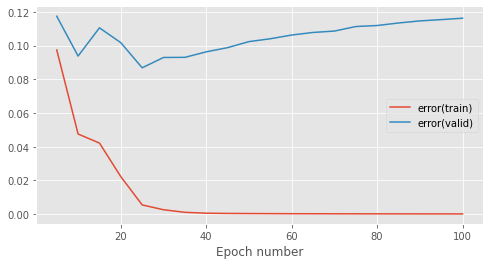

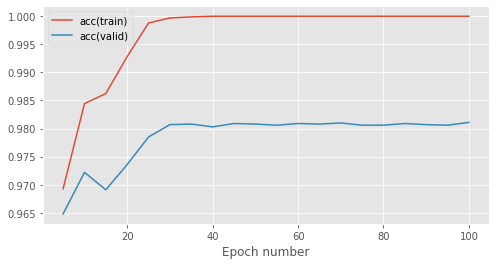

    final error(train) = 1.121e-04
    final error(valid) = 1.162e-01
    final acc(train)   = 1.000e+00
    final acc(valid)   = 9.811e-01
    run time per epoch = 3.061
-----------------------------------------------------------------------------------------------------------------------------
 num_epochs=100 batch_size=100 learning_rate=0.300 initializer=UniformInit(-0.050, 0.050) hidden_dim=300 n_hidden_layers=2
 regularizer=None regularizer_lambda=1
-----------------------------------------------------------------------------------------------------------------------------
MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=300)
    IsrluLayer(alpha=2.000)
    AffineLayer(input_dim=300, output_dim=150)
    IsrluLayer(alpha=2.000)
    AffineLayer(input_dim=150, output_dim=10)
)


Experiment Progress: 100%|██████████| 100/100 [05:41<00:00,  3.42s/it]


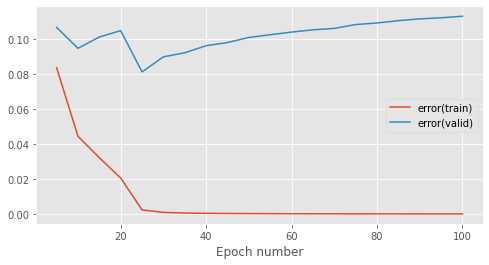

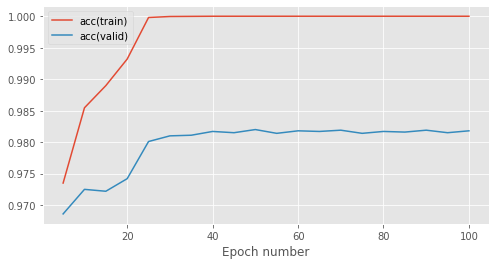

    final error(train) = 1.044e-04
    final error(valid) = 1.130e-01
    final acc(train)   = 1.000e+00
    final acc(valid)   = 9.818e-01
    run time per epoch = 3.435
-----------------------------------------------------------------------------------------------------------------------------
 num_epochs=100 batch_size=100 learning_rate=0.300 initializer=UniformInit(-0.050, 0.050) hidden_dim=300 n_hidden_layers=2
 regularizer=None regularizer_lambda=1
-----------------------------------------------------------------------------------------------------------------------------
MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=300)
    IsrluLayer(alpha=4.000)
    AffineLayer(input_dim=300, output_dim=150)
    IsrluLayer(alpha=4.000)
    AffineLayer(input_dim=150, output_dim=10)
)


Experiment Progress: 100%|██████████| 100/100 [05:08<00:00,  3.08s/it]


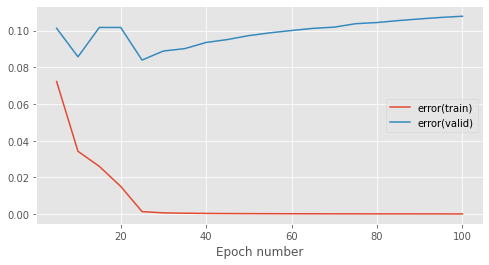

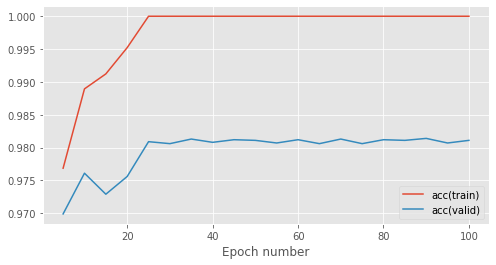

    final error(train) = 9.335e-05
    final error(valid) = 1.078e-01
    final acc(train)   = 1.000e+00
    final acc(valid)   = 9.811e-01
    run time per epoch = 3.099
-----------------------------------------------------------------------------------------------------------------------------
 num_epochs=100 batch_size=100 learning_rate=0.300 initializer=UniformInit(-0.050, 0.050) hidden_dim=300 n_hidden_layers=2
 regularizer=None regularizer_lambda=1
-----------------------------------------------------------------------------------------------------------------------------
MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=300)
    IsrluLayer(alpha=8.000)
    AffineLayer(input_dim=300, output_dim=150)
    IsrluLayer(alpha=8.000)
    AffineLayer(input_dim=150, output_dim=10)
)


Experiment Progress: 100%|██████████| 100/100 [05:06<00:00,  3.06s/it]


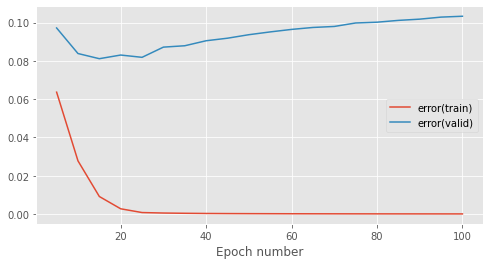

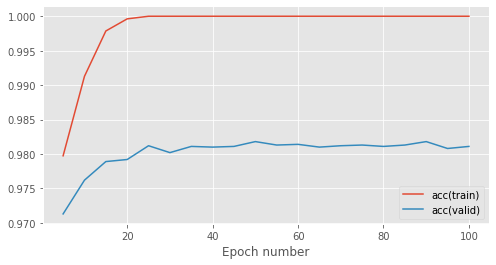

    final error(train) = 8.599e-05
    final error(valid) = 1.033e-01
    final acc(train)   = 1.000e+00
    final acc(valid)   = 9.811e-01
    run time per epoch = 3.079
-----------------------------------------------------------------------------------------------------------------------------
 num_epochs=100 batch_size=100 learning_rate=0.300 initializer=UniformInit(-0.050, 0.050) hidden_dim=300 n_hidden_layers=2
 regularizer=None regularizer_lambda=1
-----------------------------------------------------------------------------------------------------------------------------
MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=300)
    IsrluLayer(alpha=16.000)
    AffineLayer(input_dim=300, output_dim=150)
    IsrluLayer(alpha=16.000)
    AffineLayer(input_dim=150, output_dim=10)
)


Experiment Progress: 100%|██████████| 100/100 [05:07<00:00,  3.08s/it]


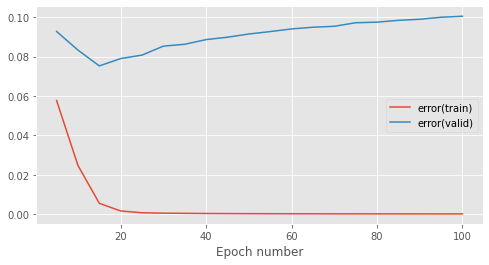

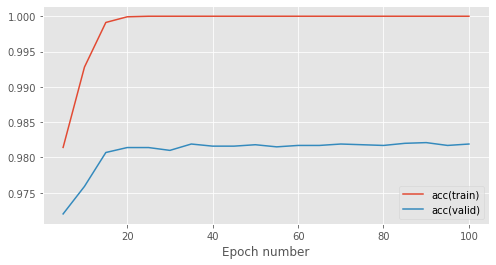

    final error(train) = 8.071e-05
    final error(valid) = 1.005e-01
    final acc(train)   = 1.000e+00
    final acc(valid)   = 9.819e-01
    run time per epoch = 3.095


In [80]:
run_grid(activation_layers=[*map(EluLayer, (0.1, 0.2, 0.4, 0.8)),
                            *map(IsrluLayer, (2, 4, 8, 16))],
         learning_rates=[0.3],
         initializers=[UniformInit(-0.05, 0.05)],
         hidden_dims=[300],
         n_hidden_layers=[2])
# Worse results than baseline model

## 1-3 Alternative Linear Units
Given the baseline model, the RELU layer was replaced by the other linear units (ELU, SELU, GELU, and ISRLU). In addition, the variable $\alpha$ was varied for the units ELU and ISRLU. The accuracy of the baseline model was not surpassed.

A possible reason could be that we didn't follow the initialization guidelines according to the corresponding papers.

According to the SELU paper, the layer allows to train deep networks with many layers, thus the advantages of SELU might not be advantageous in our 2-hidden-layer network.

Note that for $\alpha=0$ ELU is equivalent to the RELU layer, and for $\alpha \xrightarrow{} \infty$ ISRLU is equivalent to the RELU layer.

## 1-4 Initialisation Strategies
* Normalize dataset (scale to $[0, 1]$, subtract mean, divide by std)
* Use normalized initialization strategy according to [Glorot & Bengio](http://proceedings.mlr.press/v9/glorot10a.html): $W \sim U\left[-r, r\right],\ r=\sqrt\frac{6}{n_{in} + n_{out}}$
* Initialize bias to 0

### ELU
* "The weights have been initialized according to ([He et al., 2015](https://arxiv.org/abs/1502.01852))"
* Initialize weights from a normal distribution $\mathcal N(0, \sigma)$, with variance $\sigma^2=\sqrt{\frac{2}{n_{in}}}$

### SELU
* "We draw the weights from a Gaussian distribution with $E(w_i) = 0$ and
variance $Var(w_i) = 1/n_{in}$."

### GELU

* "Weights are initialized with unit norm rows, as this has positive impact on each nonlinearity’s performance"
* Pick weights such that $E\left[\sum_iw_i^2\right]=1$
* Initialize weights from a normal distribution $\mathcal N(0, \sigma)$, with variance $\sigma^2=\frac{1}{n_{in}}$

### ISRLU
* "[...] we use the same weight initialization guidelines as are used for ELU"



### Dataset normalization
Scale to $[0, 1]$, subtract mean, divide by std

In [38]:
# Print stats of MNIST data
def print_stats(train_data, valid_data):
    data = np.concatenate((train_data.inputs, valid_data.inputs))
    print(data.shape,
          np.min(data),
          np.max(data),
          np.mean(data),
          np.std(data))

print_stats(train_data, valid_data)

mnist_mean = np.mean(train_data.inputs)
mnist_std = np.std(train_data.inputs)

# Reset random number generator, create new dataset and normalize input data
rng.seed(SEED)
train_data_norm = MNISTDataProvider('train', rng=rng)
valid_data_norm = MNISTDataProvider('valid', rng=rng)
train_data_norm.inputs = (train_data_norm.inputs - mnist_mean) / mnist_std
valid_data_norm.inputs = (valid_data_norm.inputs - mnist_mean) / mnist_std

print_stats(train_data_norm, valid_data_norm)


(60000, 784) 0.0 0.99609375 0.13014998 0.30690402
(60000, 784) -0.42451638 2.8170292 -0.00097447226 0.9987461


### Glorot uniform distribution
$W \sim U\left[-r, r\right],\ r=\sqrt\frac{6}{n_{in} + n_{out}}$

-----------------------------------------------------------------------------------------------------------------------------
 num_epochs=100 batch_size=100 learning_rate=0.020 initializer=<function <lambda> at 0x129d77160> hidden_dim=300 n_hidden_layers=2
 regularizer=None regularizer_lambda=1
-----------------------------------------------------------------------------------------------------------------------------
MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=300)
    ReluLayer
    AffineLayer(input_dim=300, output_dim=150)
    ReluLayer
    AffineLayer(input_dim=150, output_dim=10)
)


Experiment Progress: 100%|██████████| 100/100 [03:47<00:00,  2.28s/it]


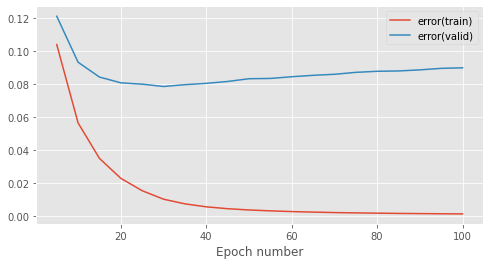

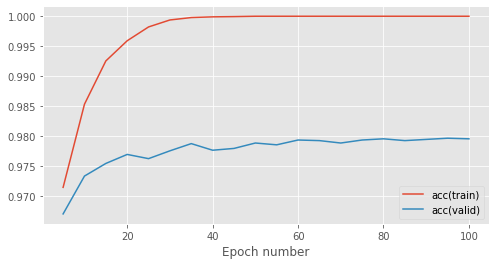

    final error(train) = 1.066e-03
    final error(valid) = 8.965e-02
    final acc(train)   = 1.000e+00
    final acc(valid)   = 9.796e-01
    run time per epoch = 2.284
-----------------------------------------------------------------------------------------------------------------------------
 num_epochs=100 batch_size=100 learning_rate=0.040 initializer=<function <lambda> at 0x129d77160> hidden_dim=300 n_hidden_layers=2
 regularizer=None regularizer_lambda=1
-----------------------------------------------------------------------------------------------------------------------------
MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=300)
    ReluLayer
    AffineLayer(input_dim=300, output_dim=150)
    ReluLayer
    AffineLayer(input_dim=150, output_dim=10)
)


Experiment Progress: 100%|██████████| 100/100 [03:45<00:00,  2.26s/it]


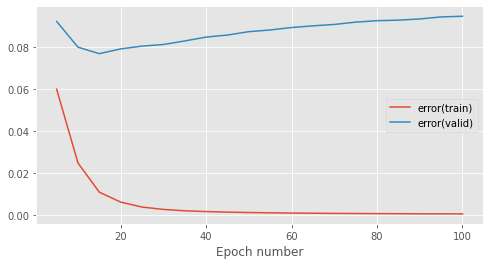

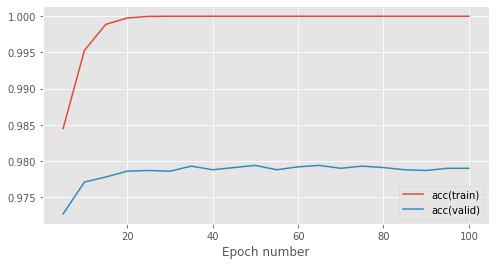

    final error(train) = 3.848e-04
    final error(valid) = 9.475e-02
    final acc(train)   = 1.000e+00
    final acc(valid)   = 9.790e-01
    run time per epoch = 2.268
-----------------------------------------------------------------------------------------------------------------------------
 num_epochs=100 batch_size=100 learning_rate=0.020 initializer=<function <lambda> at 0x129d77160> hidden_dim=300 n_hidden_layers=2
 regularizer=None regularizer_lambda=1
-----------------------------------------------------------------------------------------------------------------------------
MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=300)
    EluLayer(alpha=1.000)
    AffineLayer(input_dim=300, output_dim=150)
    EluLayer(alpha=1.000)
    AffineLayer(input_dim=150, output_dim=10)
)


Experiment Progress: 100%|██████████| 100/100 [05:13<00:00,  3.14s/it]


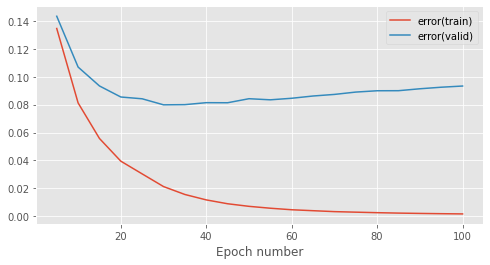

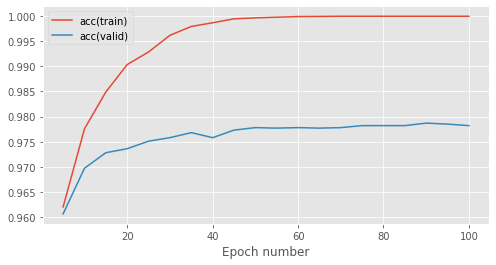

    final error(train) = 1.717e-03
    final error(valid) = 9.334e-02
    final acc(train)   = 1.000e+00
    final acc(valid)   = 9.782e-01
    run time per epoch = 3.151
-----------------------------------------------------------------------------------------------------------------------------
 num_epochs=100 batch_size=100 learning_rate=0.040 initializer=<function <lambda> at 0x129d77160> hidden_dim=300 n_hidden_layers=2
 regularizer=None regularizer_lambda=1
-----------------------------------------------------------------------------------------------------------------------------
MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=300)
    EluLayer(alpha=1.000)
    AffineLayer(input_dim=300, output_dim=150)
    EluLayer(alpha=1.000)
    AffineLayer(input_dim=150, output_dim=10)
)


Experiment Progress: 100%|██████████| 100/100 [05:09<00:00,  3.09s/it]


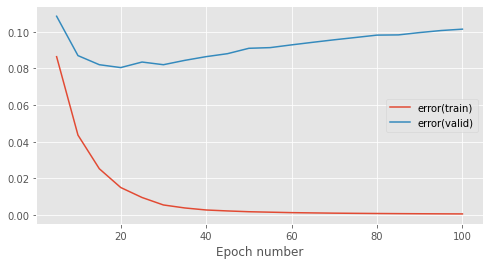

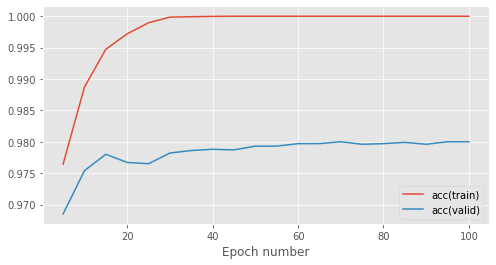

    final error(train) = 5.480e-04
    final error(valid) = 1.015e-01
    final acc(train)   = 1.000e+00
    final acc(valid)   = 9.800e-01
    run time per epoch = 3.111
-----------------------------------------------------------------------------------------------------------------------------
 num_epochs=100 batch_size=100 learning_rate=0.020 initializer=<function <lambda> at 0x129d77160> hidden_dim=300 n_hidden_layers=2
 regularizer=None regularizer_lambda=1
-----------------------------------------------------------------------------------------------------------------------------
MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=300)
    SeluLayer
    AffineLayer(input_dim=300, output_dim=150)
    SeluLayer
    AffineLayer(input_dim=150, output_dim=10)
)


Experiment Progress: 100%|██████████| 100/100 [05:09<00:00,  3.10s/it]


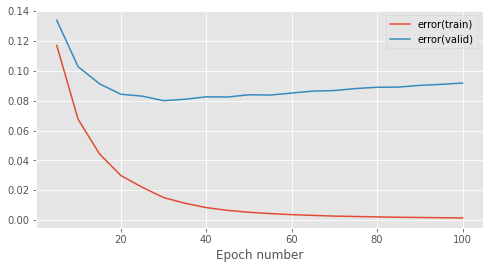

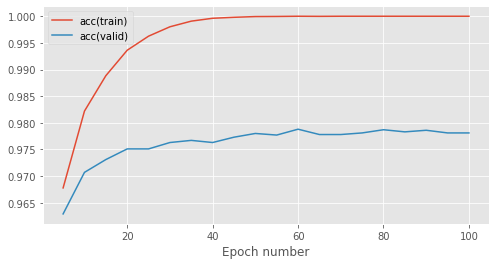

    final error(train) = 1.498e-03
    final error(valid) = 9.181e-02
    final acc(train)   = 1.000e+00
    final acc(valid)   = 9.781e-01
    run time per epoch = 3.112
-----------------------------------------------------------------------------------------------------------------------------
 num_epochs=100 batch_size=100 learning_rate=0.040 initializer=<function <lambda> at 0x129d77160> hidden_dim=300 n_hidden_layers=2
 regularizer=None regularizer_lambda=1
-----------------------------------------------------------------------------------------------------------------------------
MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=300)
    SeluLayer
    AffineLayer(input_dim=300, output_dim=150)
    SeluLayer
    AffineLayer(input_dim=150, output_dim=10)
)


Experiment Progress: 100%|██████████| 100/100 [05:08<00:00,  3.08s/it]


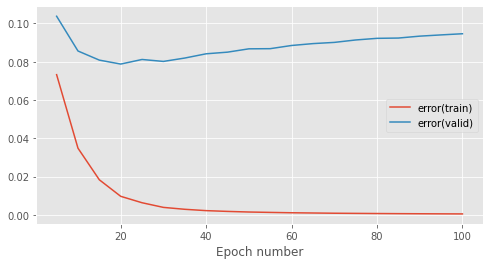

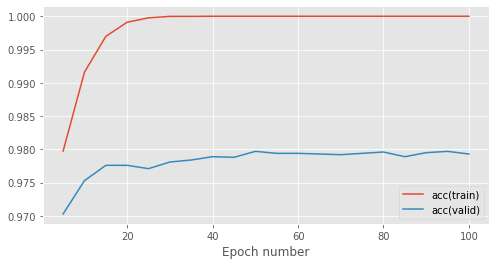

    final error(train) = 5.294e-04
    final error(valid) = 9.458e-02
    final acc(train)   = 1.000e+00
    final acc(valid)   = 9.793e-01
    run time per epoch = 3.097
-----------------------------------------------------------------------------------------------------------------------------
 num_epochs=100 batch_size=100 learning_rate=0.020 initializer=<function <lambda> at 0x129d77160> hidden_dim=300 n_hidden_layers=2
 regularizer=None regularizer_lambda=1
-----------------------------------------------------------------------------------------------------------------------------
MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=300)
    GeluLayer
    AffineLayer(input_dim=300, output_dim=150)
    GeluLayer
    AffineLayer(input_dim=150, output_dim=10)
)


Experiment Progress: 100%|██████████| 100/100 [05:35<00:00,  3.36s/it]


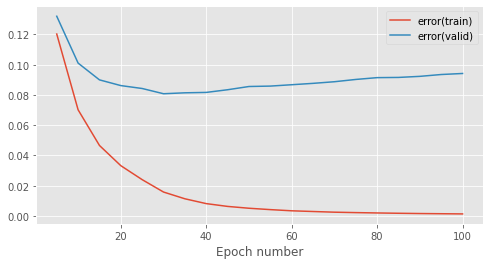

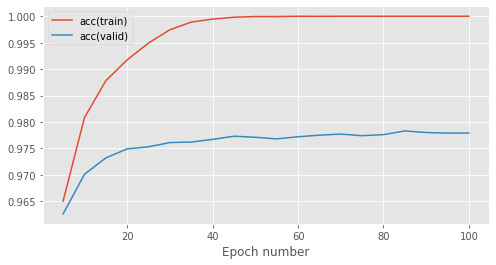

    final error(train) = 1.325e-03
    final error(valid) = 9.421e-02
    final acc(train)   = 1.000e+00
    final acc(valid)   = 9.779e-01
    run time per epoch = 3.370
-----------------------------------------------------------------------------------------------------------------------------
 num_epochs=100 batch_size=100 learning_rate=0.040 initializer=<function <lambda> at 0x129d77160> hidden_dim=300 n_hidden_layers=2
 regularizer=None regularizer_lambda=1
-----------------------------------------------------------------------------------------------------------------------------
MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=300)
    GeluLayer
    AffineLayer(input_dim=300, output_dim=150)
    GeluLayer
    AffineLayer(input_dim=150, output_dim=10)
)


Experiment Progress: 100%|██████████| 100/100 [05:34<00:00,  3.35s/it]


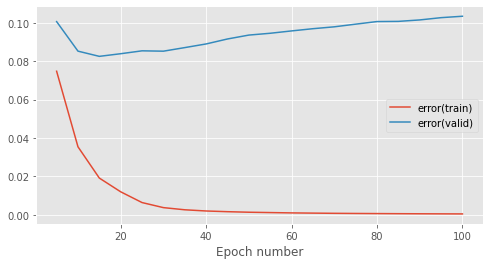

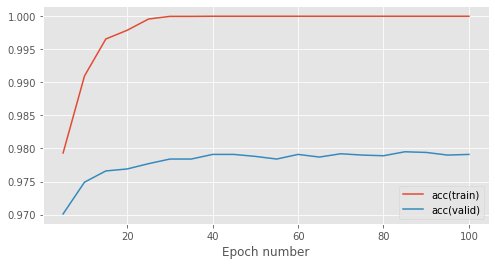

    final error(train) = 4.428e-04
    final error(valid) = 1.034e-01
    final acc(train)   = 1.000e+00
    final acc(valid)   = 9.791e-01
    run time per epoch = 3.360
-----------------------------------------------------------------------------------------------------------------------------
 num_epochs=100 batch_size=100 learning_rate=0.020 initializer=<function <lambda> at 0x129d77160> hidden_dim=300 n_hidden_layers=2
 regularizer=None regularizer_lambda=1
-----------------------------------------------------------------------------------------------------------------------------
MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=300)
    IsrluLayer(alpha=1.000)
    AffineLayer(input_dim=300, output_dim=150)
    IsrluLayer(alpha=1.000)
    AffineLayer(input_dim=150, output_dim=10)
)


Experiment Progress: 100%|██████████| 100/100 [05:04<00:00,  3.04s/it]


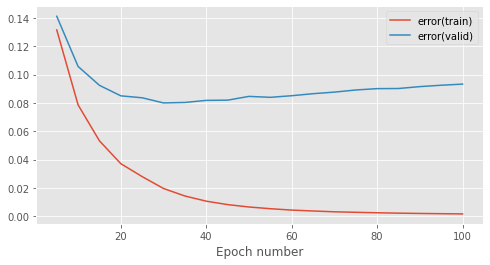

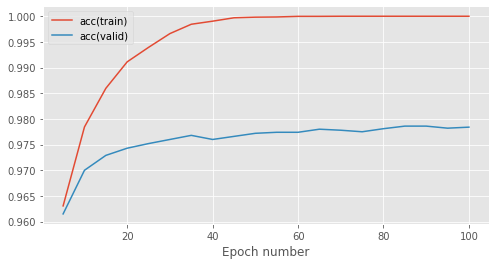

    final error(train) = 1.616e-03
    final error(valid) = 9.330e-02
    final acc(train)   = 1.000e+00
    final acc(valid)   = 9.784e-01
    run time per epoch = 3.058
-----------------------------------------------------------------------------------------------------------------------------
 num_epochs=100 batch_size=100 learning_rate=0.040 initializer=<function <lambda> at 0x129d77160> hidden_dim=300 n_hidden_layers=2
 regularizer=None regularizer_lambda=1
-----------------------------------------------------------------------------------------------------------------------------
MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=300)
    IsrluLayer(alpha=1.000)
    AffineLayer(input_dim=300, output_dim=150)
    IsrluLayer(alpha=1.000)
    AffineLayer(input_dim=150, output_dim=10)
)


Experiment Progress: 100%|██████████| 100/100 [05:05<00:00,  3.05s/it]


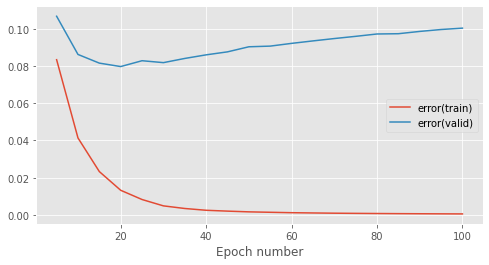

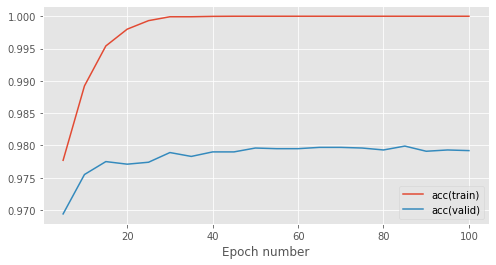

    final error(train) = 5.262e-04
    final error(valid) = 1.004e-01
    final acc(train)   = 1.000e+00
    final acc(valid)   = 9.792e-01
    run time per epoch = 3.068


In [70]:
run_grid(activation_layers=[ReluLayer(),
                            EluLayer(),
                            SeluLayer(),
                            GeluLayer(),
                            IsrluLayer()],
         learning_rates=[0.02, 0.04],
         initializers=[lambda n_in, n_out: UniformInit(-(6 / (n_in + n_out)) ** 0.5, (6 / (n_in + n_out)) ** 0.5)],
         hidden_dims=[300],
         n_hidden_layers=[2],
         train_data=train_data_norm,
         valid_data=valid_data_norm)
# No accuracy improvement

### ELU initialization strategy
Initialize weights from a normal distribution $\mathcal N(0, \sigma)$, with variance $\sigma^2=\sqrt{\frac{2}{n_{in}}}$

-----------------------------------------------------------------------------------------------------------------------------
 num_epochs=100 batch_size=100 learning_rate=0.010 initializer=<function <lambda> at 0x1275e0280> hidden_dim=300 n_hidden_layers=2
 regularizer=None regularizer_lambda=1
-----------------------------------------------------------------------------------------------------------------------------
MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=300)
    EluLayer(alpha=1.000)
    AffineLayer(input_dim=300, output_dim=150)
    EluLayer(alpha=1.000)
    AffineLayer(input_dim=150, output_dim=10)
)


Experiment Progress: 100%|██████████| 100/100 [05:05<00:00,  3.06s/it]


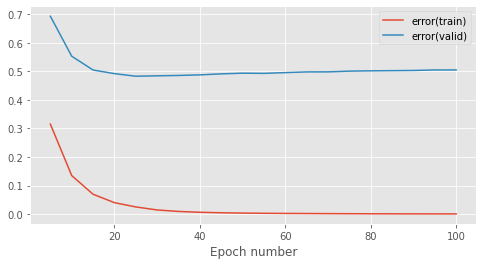

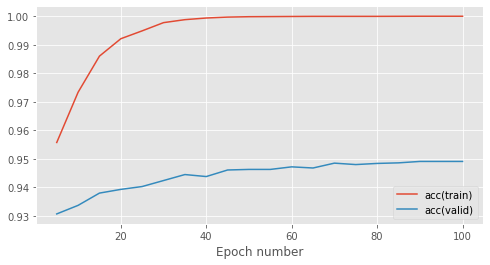

    final error(train) = 1.024e-03
    final error(valid) = 5.049e-01
    final acc(train)   = 1.000e+00
    final acc(valid)   = 9.491e-01
    run time per epoch = 3.072
-----------------------------------------------------------------------------------------------------------------------------
 num_epochs=100 batch_size=100 learning_rate=0.020 initializer=<function <lambda> at 0x1275e0280> hidden_dim=300 n_hidden_layers=2
 regularizer=None regularizer_lambda=1
-----------------------------------------------------------------------------------------------------------------------------
MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=300)
    EluLayer(alpha=1.000)
    AffineLayer(input_dim=300, output_dim=150)
    EluLayer(alpha=1.000)
    AffineLayer(input_dim=150, output_dim=10)
)


Experiment Progress: 100%|██████████| 100/100 [05:04<00:00,  3.05s/it]


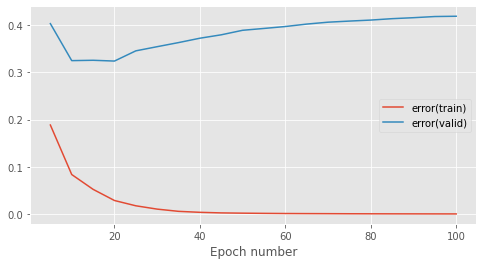

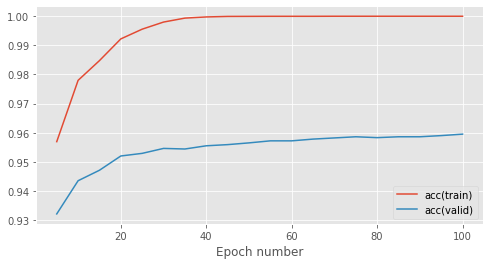

    final error(train) = 5.047e-04
    final error(valid) = 4.183e-01
    final acc(train)   = 1.000e+00
    final acc(valid)   = 9.595e-01
    run time per epoch = 3.062


In [79]:
run_grid(activation_layers=[EluLayer()],
         learning_rates=[0.01, 0.02],
         initializers=[lambda n_in, _: NormalInit(0, (2 / n_in) ** 0.25)],
         hidden_dims=[300],
         n_hidden_layers=[2],
         train_data=train_data_norm,
         valid_data=valid_data_norm)

### SELU initialization strategy
Initialize weights from a normal distribution $\mathcal N(0, \sigma)$, with variance $\sigma^2=\frac{1}{n_{in}}$

-----------------------------------------------------------------------------------------------------------------------------
 num_epochs=100 batch_size=100 learning_rate=0.040 initializer=<function <lambda> at 0x12761a1f0> hidden_dim=300 n_hidden_layers=2
 regularizer=None regularizer_lambda=1
-----------------------------------------------------------------------------------------------------------------------------
MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=300)
    SeluLayer
    AffineLayer(input_dim=300, output_dim=150)
    SeluLayer
    AffineLayer(input_dim=150, output_dim=10)
)


Experiment Progress: 100%|██████████| 100/100 [04:43<00:00,  2.83s/it]


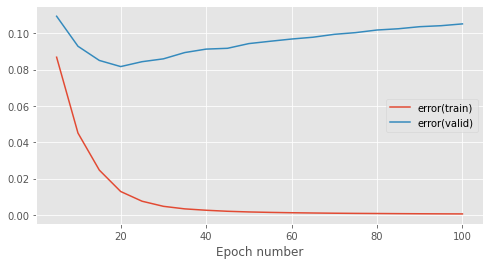

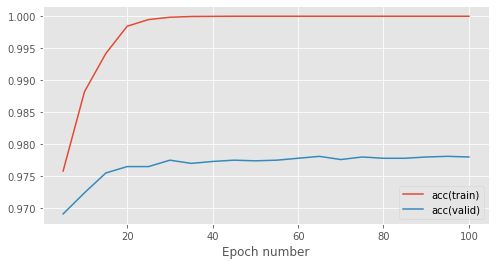

    final error(train) = 5.319e-04
    final error(valid) = 1.051e-01
    final acc(train)   = 1.000e+00
    final acc(valid)   = 9.780e-01
    run time per epoch = 2.847
-----------------------------------------------------------------------------------------------------------------------------
 num_epochs=100 batch_size=100 learning_rate=0.080 initializer=<function <lambda> at 0x12761a1f0> hidden_dim=300 n_hidden_layers=2
 regularizer=None regularizer_lambda=1
-----------------------------------------------------------------------------------------------------------------------------
MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=300)
    SeluLayer
    AffineLayer(input_dim=300, output_dim=150)
    SeluLayer
    AffineLayer(input_dim=150, output_dim=10)
)


Experiment Progress: 100%|██████████| 100/100 [04:33<00:00,  2.74s/it]


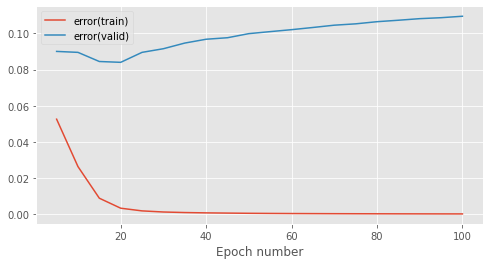

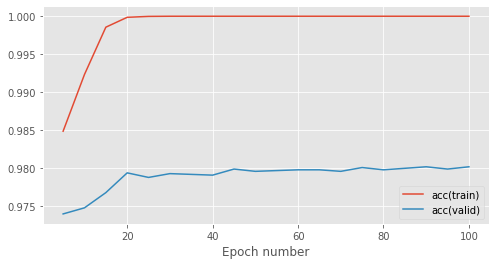

    final error(train) = 2.073e-04
    final error(valid) = 1.095e-01
    final acc(train)   = 1.000e+00
    final acc(valid)   = 9.802e-01
    run time per epoch = 2.752


In [71]:
run_grid(activation_layers=[SeluLayer()],
         learning_rates=[0.04, 0.08],
         initializers=[lambda n_in, _: NormalInit(0, (1 / n_in) ** 0.5)],
         hidden_dims=[300],
         n_hidden_layers=[2],
         train_data=train_data_norm,
         valid_data=valid_data_norm)

### GELU initialization strategy
Initialize weights from a normal distribution $\mathcal N(0, \sigma)$, with variance $\sigma^2=\frac{1}{n_{in}}$

-----------------------------------------------------------------------------------------------------------------------------
 num_epochs=100 batch_size=100 learning_rate=0.040 initializer=<function <lambda> at 0x1274505e0> hidden_dim=300 n_hidden_layers=2
 regularizer=None regularizer_lambda=1
-----------------------------------------------------------------------------------------------------------------------------
MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=300)
    GeluLayer
    AffineLayer(input_dim=300, output_dim=150)
    GeluLayer
    AffineLayer(input_dim=150, output_dim=10)
)


Experiment Progress: 100%|██████████| 100/100 [04:46<00:00,  2.86s/it]


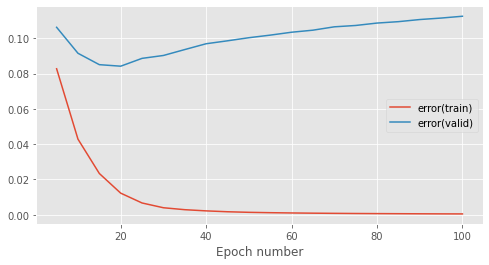

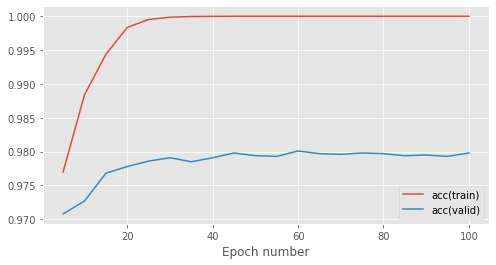

    final error(train) = 4.456e-04
    final error(valid) = 1.126e-01
    final acc(train)   = 1.000e+00
    final acc(valid)   = 9.798e-01
    run time per epoch = 2.871
-----------------------------------------------------------------------------------------------------------------------------
 num_epochs=100 batch_size=100 learning_rate=0.080 initializer=<function <lambda> at 0x1274505e0> hidden_dim=300 n_hidden_layers=2
 regularizer=None regularizer_lambda=1
-----------------------------------------------------------------------------------------------------------------------------
MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=300)
    GeluLayer
    AffineLayer(input_dim=300, output_dim=150)
    GeluLayer
    AffineLayer(input_dim=150, output_dim=10)
)


Experiment Progress: 100%|██████████| 100/100 [04:47<00:00,  2.88s/it]


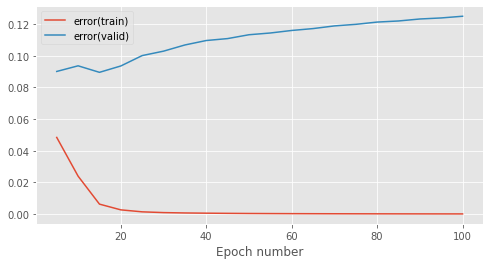

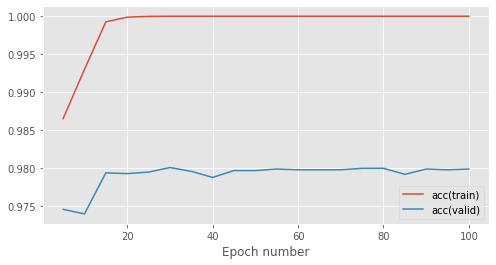

    final error(train) = 1.678e-04
    final error(valid) = 1.249e-01
    final acc(train)   = 1.000e+00
    final acc(valid)   = 9.799e-01
    run time per epoch = 2.886


In [72]:
run_grid(activation_layers=[GeluLayer()],
         learning_rates=[0.04, 0.08],
         initializers=[lambda n_in, _: NormalInit(0, (1 / n_in) ** 0.5)],
         hidden_dims=[300],
         n_hidden_layers=[2],
         train_data=train_data_norm,
         valid_data=valid_data_norm)

### ISRLU initialization strategy
Initialize weights from a normal distribution $\mathcal N(0, \sigma)$, with variance $\sigma^2=\sqrt{\frac{2}{n_{in}}}$

-----------------------------------------------------------------------------------------------------------------------------
 num_epochs=100 batch_size=100 learning_rate=0.020 initializer=<function <lambda> at 0x12bd95160> hidden_dim=300 n_hidden_layers=2
 regularizer=None regularizer_lambda=1
-----------------------------------------------------------------------------------------------------------------------------
MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=300)
    IsrluLayer(alpha=1.000)
    AffineLayer(input_dim=300, output_dim=150)
    IsrluLayer(alpha=1.000)
    AffineLayer(input_dim=150, output_dim=10)
)


Experiment Progress: 100%|██████████| 100/100 [04:45<00:00,  2.85s/it]


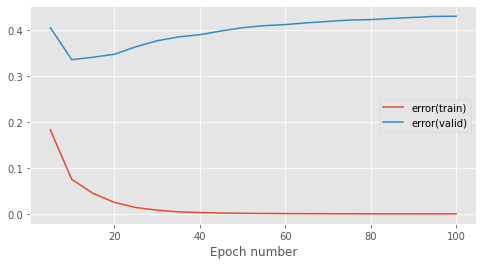

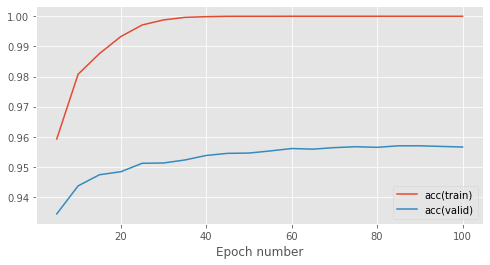

    final error(train) = 4.825e-04
    final error(valid) = 4.305e-01
    final acc(train)   = 1.000e+00
    final acc(valid)   = 9.566e-01
    run time per epoch = 2.864
-----------------------------------------------------------------------------------------------------------------------------
 num_epochs=100 batch_size=100 learning_rate=0.040 initializer=<function <lambda> at 0x12bd95160> hidden_dim=300 n_hidden_layers=2
 regularizer=None regularizer_lambda=1
-----------------------------------------------------------------------------------------------------------------------------
MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=300)
    IsrluLayer(alpha=1.000)
    AffineLayer(input_dim=300, output_dim=150)
    IsrluLayer(alpha=1.000)
    AffineLayer(input_dim=150, output_dim=10)
)


Experiment Progress: 100%|██████████| 100/100 [04:41<00:00,  2.81s/it]


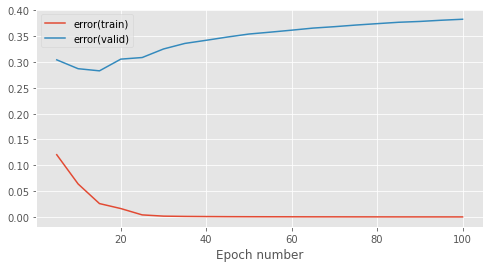

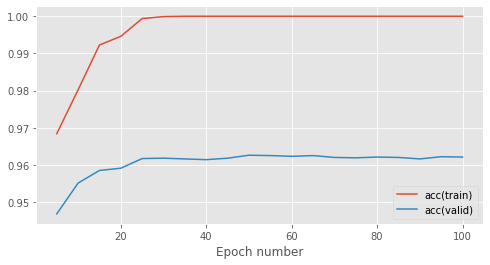

    final error(train) = 2.133e-04
    final error(valid) = 3.826e-01
    final acc(train)   = 1.000e+00
    final acc(valid)   = 9.621e-01
    run time per epoch = 2.825


In [73]:
run_grid(activation_layers=[IsrluLayer()],
         learning_rates=[0.02, 0.04],
         initializers=[lambda n_in, _: NormalInit(0, (2 / n_in) ** 0.25)],
         hidden_dims=[300],
         n_hidden_layers=[2],
         train_data=train_data_norm,
         valid_data=valid_data_norm)

No improvement of the baseline model could be found, despite the special initialization strategies.

It was observed that the baseline training rate did not work for the special initialization technique, and further parameter search would be necessary to find the optimal training rate for those weight initialization policies.

## 1-5
a) Accuracy improvements:
* L2 regularizer
* L1 regularizer
* Data augmentation
* Dropout layer
* In-depth hyper-parameter optimization (e.g. using grid or bayesian search)
* Adaptive learning rate, e.g. learning rate schedule or line search
* Convolution + pooling layer instead of affine layer
* Ensemble of networks
* Alternative learning methods, e.g. momentum

b) Training speed:
* Low-level implementation in compiled language (e.g. C++)
* Parallel computing (mini-batch spread over different CPUs / clusters)
* Use some optimized DL framework such as Tensorflow / Keras, Cafe2, PyTorch
* Run on computer with high FLOPS
* Reduce number of trainable parameters (= simplify model)
* Use a method that converges faster, e.g. momentum learning method or batch normalization

c) Inference speed:
* Low-level implementation in compiled language (e.g. C++)
* Use some optimized DL framework such as Tensorflow / Keras, Cafe2, PyTorch
* Run on computer with high FLOPS
* Reduce number of operations required for a forward pass (= simplify model)

### L2 regularization
Try to improve accuracy using L2 regularizer and search for optimal regularization factor

-----------------------------------------------------------------------------------------------------------------------------
 num_epochs=100 batch_size=100 learning_rate=0.300 initializer=UniformInit(-0.050, 0.050) hidden_dim=300 n_hidden_layers=2
 regularizer=L2 regularizer_lambda=0
-----------------------------------------------------------------------------------------------------------------------------
MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=300)
    ReluLayer
    AffineLayer(input_dim=300, output_dim=150)
    ReluLayer
    AffineLayer(input_dim=150, output_dim=10)
)


Experiment Progress: 100%|██████████| 100/100 [03:32<00:00,  2.13s/it]


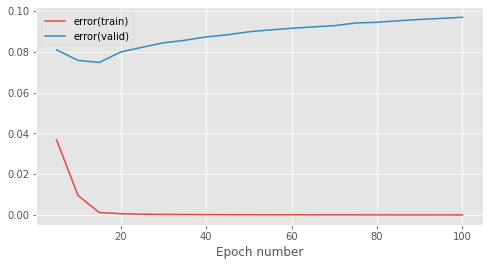

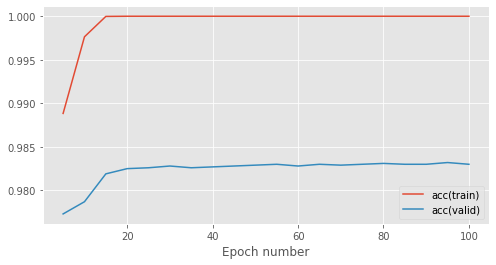

    final error(train) = 6.472e-05
    final error(valid) = 9.701e-02
    final acc(train)   = 1.000e+00
    final acc(valid)   = 9.830e-01
    run time per epoch = 2.139
-----------------------------------------------------------------------------------------------------------------------------
 num_epochs=100 batch_size=100 learning_rate=0.300 initializer=UniformInit(-0.050, 0.050) hidden_dim=300 n_hidden_layers=2
 regularizer=L2 regularizer_lambda=1e-06
-----------------------------------------------------------------------------------------------------------------------------
MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=300)
    ReluLayer
    AffineLayer(input_dim=300, output_dim=150)
    ReluLayer
    AffineLayer(input_dim=150, output_dim=10)
)


Experiment Progress: 100%|██████████| 100/100 [03:29<00:00,  2.10s/it]


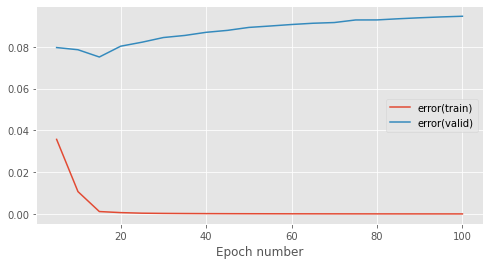

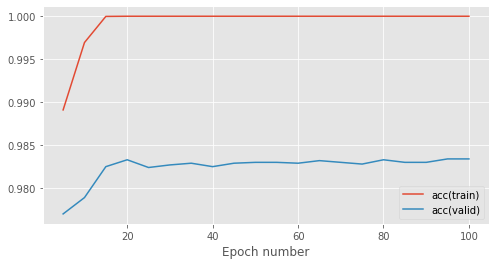

    final error(train) = 1.112e-04
    final error(valid) = 9.454e-02
    final acc(train)   = 1.000e+00
    final acc(valid)   = 9.834e-01
    run time per epoch = 2.108
-----------------------------------------------------------------------------------------------------------------------------
 num_epochs=100 batch_size=100 learning_rate=0.300 initializer=UniformInit(-0.050, 0.050) hidden_dim=300 n_hidden_layers=2
 regularizer=L2 regularizer_lambda=1e-05
-----------------------------------------------------------------------------------------------------------------------------
MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=300)
    ReluLayer
    AffineLayer(input_dim=300, output_dim=150)
    ReluLayer
    AffineLayer(input_dim=150, output_dim=10)
)


Experiment Progress: 100%|██████████| 100/100 [03:29<00:00,  2.10s/it]


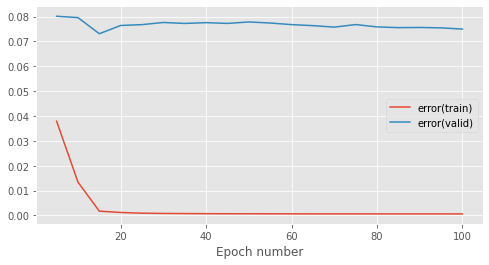

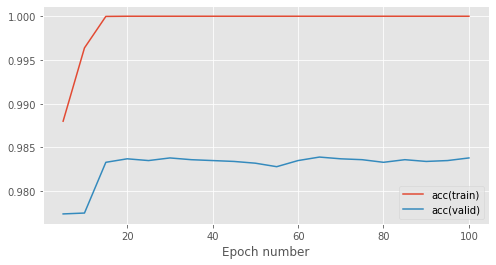

    final error(train) = 5.982e-04
    final error(valid) = 7.496e-02
    final acc(train)   = 1.000e+00
    final acc(valid)   = 9.838e-01
    run time per epoch = 2.108
-----------------------------------------------------------------------------------------------------------------------------
 num_epochs=100 batch_size=100 learning_rate=0.300 initializer=UniformInit(-0.050, 0.050) hidden_dim=300 n_hidden_layers=2
 regularizer=L2 regularizer_lambda=0.0001
-----------------------------------------------------------------------------------------------------------------------------
MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=300)
    ReluLayer
    AffineLayer(input_dim=300, output_dim=150)
    ReluLayer
    AffineLayer(input_dim=150, output_dim=10)
)


Experiment Progress: 100%|██████████| 100/100 [03:29<00:00,  2.09s/it]


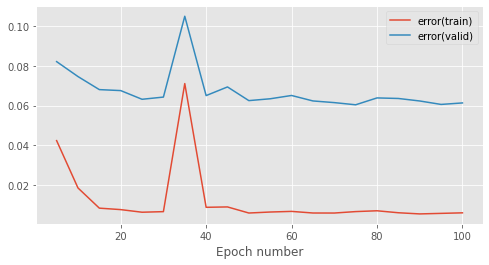

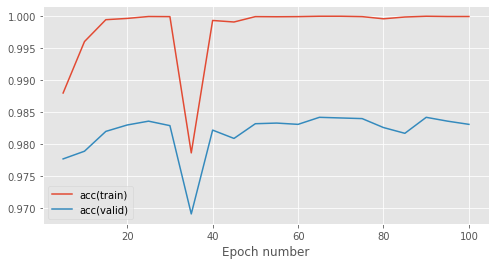

    final error(train) = 5.778e-03
    final error(valid) = 6.130e-02
    final acc(train)   = 1.000e+00
    final acc(valid)   = 9.831e-01
    run time per epoch = 2.102
-----------------------------------------------------------------------------------------------------------------------------
 num_epochs=100 batch_size=100 learning_rate=0.300 initializer=UniformInit(-0.050, 0.050) hidden_dim=300 n_hidden_layers=2
 regularizer=L2 regularizer_lambda=0.001
-----------------------------------------------------------------------------------------------------------------------------
MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=300)
    ReluLayer
    AffineLayer(input_dim=300, output_dim=150)
    ReluLayer
    AffineLayer(input_dim=150, output_dim=10)
)


Experiment Progress: 100%|██████████| 100/100 [03:29<00:00,  2.10s/it]


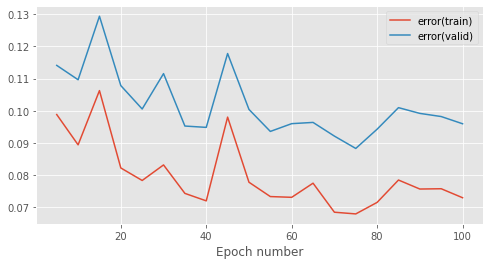

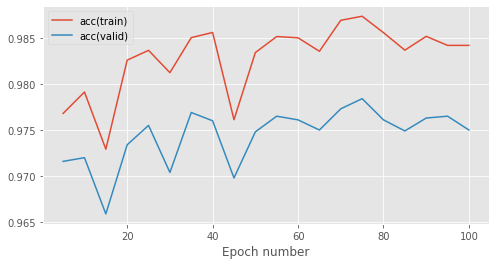

    final error(train) = 7.302e-02
    final error(valid) = 9.599e-02
    final acc(train)   = 9.842e-01
    final acc(valid)   = 9.750e-01
    run time per epoch = 2.106


In [76]:
run_grid(learning_rates=[0.3],
         initializers=[UniformInit(-0.05, 0.05)],
         hidden_dims=[300],
         n_hidden_layers=[2],
         regularizers=['L2'],
         regularizer_lambdas=[0, 1e-6, 1e-5, 1e-4, 1e-3])
# Pick lambda=1e-5

-----------------------------------------------------------------------------------------------------------------------------
 num_epochs=100 batch_size=100 learning_rate=0.300 initializer=UniformInit(-0.050, 0.050) hidden_dim=300 n_hidden_layers=2
 regularizer=L2 regularizer_lambda=2.5e-06
-----------------------------------------------------------------------------------------------------------------------------
MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=300)
    ReluLayer
    AffineLayer(input_dim=300, output_dim=150)
    ReluLayer
    AffineLayer(input_dim=150, output_dim=10)
)


Experiment Progress: 100%|██████████| 100/100 [34:35<00:00, 20.76s/it]  


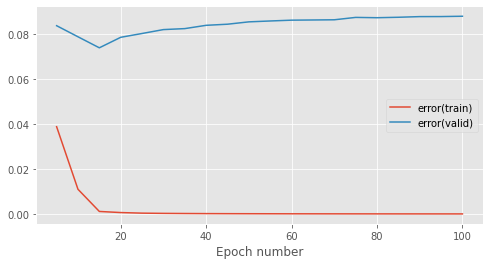

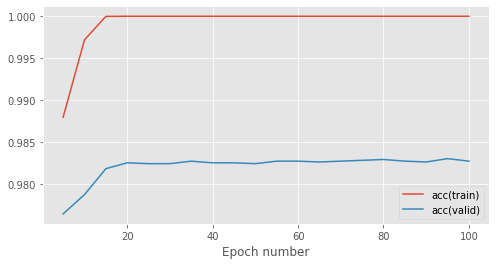

    final error(train) = 1.850e-04
    final error(valid) = 8.791e-02
    final acc(train)   = 1.000e+00
    final acc(valid)   = 9.827e-01
    run time per epoch = 20.769
-----------------------------------------------------------------------------------------------------------------------------
 num_epochs=100 batch_size=100 learning_rate=0.300 initializer=UniformInit(-0.050, 0.050) hidden_dim=300 n_hidden_layers=2
 regularizer=L2 regularizer_lambda=5e-06
-----------------------------------------------------------------------------------------------------------------------------
MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=300)
    ReluLayer
    AffineLayer(input_dim=300, output_dim=150)
    ReluLayer
    AffineLayer(input_dim=150, output_dim=10)
)


Experiment Progress: 100%|██████████| 100/100 [06:46<00:00,  4.07s/it]


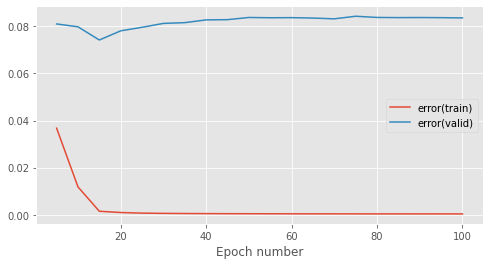

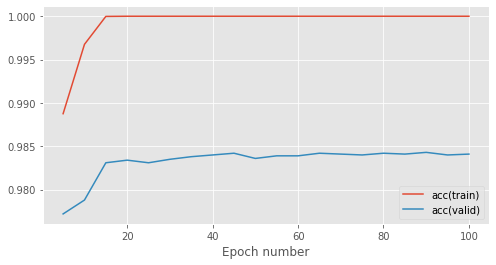

    final error(train) = 3.178e-04
    final error(valid) = 8.362e-02
    final acc(train)   = 1.000e+00
    final acc(valid)   = 9.841e-01
    run time per epoch = 4.087
-----------------------------------------------------------------------------------------------------------------------------
 num_epochs=100 batch_size=100 learning_rate=0.300 initializer=UniformInit(-0.050, 0.050) hidden_dim=300 n_hidden_layers=2
 regularizer=L2 regularizer_lambda=1e-05
-----------------------------------------------------------------------------------------------------------------------------
MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=300)
    ReluLayer
    AffineLayer(input_dim=300, output_dim=150)
    ReluLayer
    AffineLayer(input_dim=150, output_dim=10)
)


Experiment Progress: 100%|██████████| 100/100 [06:50<00:00,  4.11s/it]


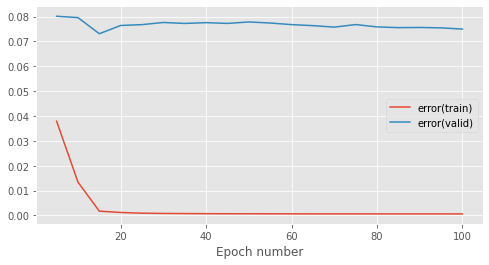

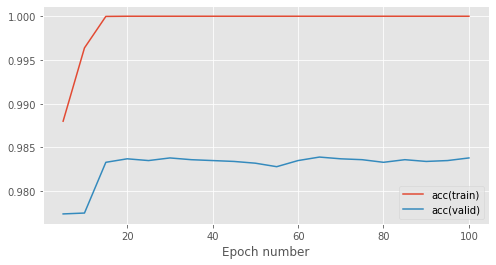

    final error(train) = 5.982e-04
    final error(valid) = 7.496e-02
    final acc(train)   = 1.000e+00
    final acc(valid)   = 9.838e-01
    run time per epoch = 4.126
-----------------------------------------------------------------------------------------------------------------------------
 num_epochs=100 batch_size=100 learning_rate=0.300 initializer=UniformInit(-0.050, 0.050) hidden_dim=300 n_hidden_layers=2
 regularizer=L2 regularizer_lambda=2e-05
-----------------------------------------------------------------------------------------------------------------------------
MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=300)
    ReluLayer
    AffineLayer(input_dim=300, output_dim=150)
    ReluLayer
    AffineLayer(input_dim=150, output_dim=10)
)


Experiment Progress: 100%|██████████| 100/100 [06:50<00:00,  4.10s/it]


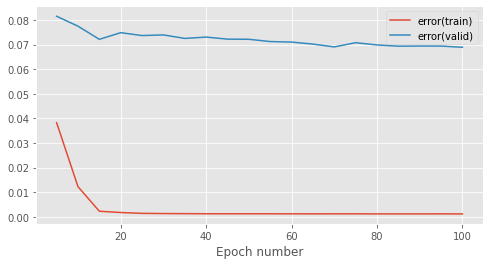

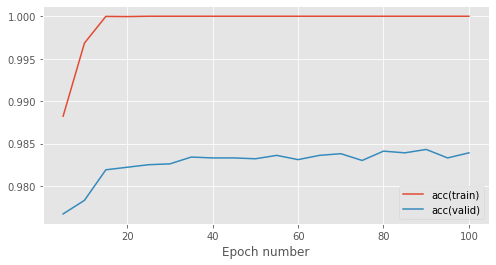

    final error(train) = 1.159e-03
    final error(valid) = 6.888e-02
    final acc(train)   = 1.000e+00
    final acc(valid)   = 9.839e-01
    run time per epoch = 4.122
-----------------------------------------------------------------------------------------------------------------------------
 num_epochs=100 batch_size=100 learning_rate=0.300 initializer=UniformInit(-0.050, 0.050) hidden_dim=300 n_hidden_layers=2
 regularizer=L2 regularizer_lambda=4e-05
-----------------------------------------------------------------------------------------------------------------------------
MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=300)
    ReluLayer
    AffineLayer(input_dim=300, output_dim=150)
    ReluLayer
    AffineLayer(input_dim=150, output_dim=10)
)


Experiment Progress: 100%|██████████| 100/100 [06:51<00:00,  4.11s/it]


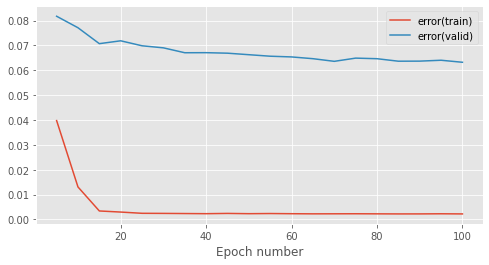

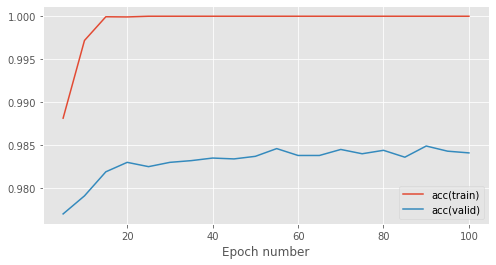

    final error(train) = 2.237e-03
    final error(valid) = 6.321e-02
    final acc(train)   = 1.000e+00
    final acc(valid)   = 9.841e-01
    run time per epoch = 4.133


In [77]:
run_grid(learning_rates=[0.3],
         initializers=[UniformInit(-0.05, 0.05)],
         hidden_dims=[300],
         n_hidden_layers=[2],
         regularizers=['L2'],
         regularizer_lambdas=[2.5e-6, 5e-6, 1e-5, 2e-5, 4e-5])
# Pick lambda=4e-5

With the an L2 regulariation ($\hat C = C + \lambda||w||_2, \lambda=4\cdot10^{-5}$) I achieved an accuracy of __98.41%__ (vs. baseline model 98.30%). This is as expected since the regularizer penalizes large weights and forces the model to reduce variance (prevents overfitting).

Next, I try to speed up traning by using a momentum learning rule. 

### Momentum-adapted learning rule
Run baseline model with and without momentum-adapted learning rule

-----------------------------------------------------------------------------------------------------------------------------
 num_epochs=100 batch_size=100 learning_rate=0.300 initializer=UniformInit(-0.050, 0.050) hidden_dim=300 n_hidden_layers=2
 regularizer=None regularizer_lambda=1
-----------------------------------------------------------------------------------------------------------------------------
MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=300)
    ReluLayer
    AffineLayer(input_dim=300, output_dim=150)
    ReluLayer
    AffineLayer(input_dim=150, output_dim=10)
)


Experiment Progress: 100%|██████████| 100/100 [03:50<00:00,  2.31s/it]


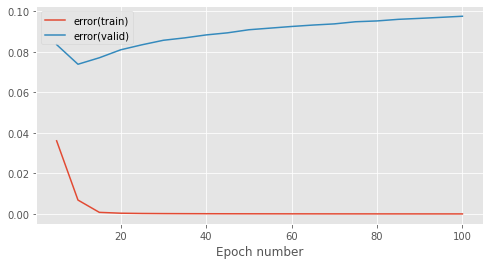

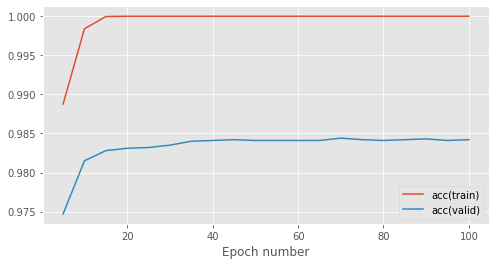

    final error(train) = 4.578e-05
    final error(valid) = 9.749e-02
    final acc(train)   = 1.000e+00
    final acc(valid)   = 9.842e-01
    run time per epoch = 2.315


MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=300)
    ReluLayer
    AffineLayer(input_dim=300, output_dim=150)
    ReluLayer
    AffineLayer(input_dim=150, output_dim=10)
)

In [92]:
run(learning_rate=0.3,
    initializer=UniformInit(-0.05, 0.05),
    hidden_dim=300,
    n_hidden_layers=2,
    learning_rule_cls=lambda learning_rate: MomentumLearningRule(learning_rate, 0.2))

Using the momentum-adapted learning rule and looking at the training plots we can observe that the validation accuracy is converging faster (compared to the baseline model).

Note that using the momentum-adapted learning rule I achieved the highest validation accuracy of __98.42%__. This is as expected, as the momentum-adapted learning rule accelerates the training and we reach a higher accuracy in the 100 training epochs.

Next, I'll combine the best performing settings, the momentum-adapted learning rule and the L2-regularizer, and inspect the results.

-----------------------------------------------------------------------------------------------------------------------------
 num_epochs=100 batch_size=100 learning_rate=0.300 initializer=UniformInit(-0.050, 0.050) hidden_dim=300 n_hidden_layers=2
 regularizer=L2 regularizer_lambda=2e-05
-----------------------------------------------------------------------------------------------------------------------------
MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=300)
    ReluLayer
    AffineLayer(input_dim=300, output_dim=150)
    ReluLayer
    AffineLayer(input_dim=150, output_dim=10)
)


Experiment Progress: 100%|██████████| 100/100 [04:01<00:00,  2.42s/it]


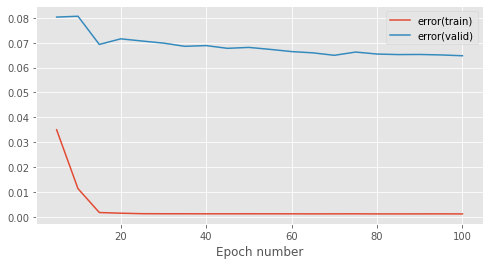

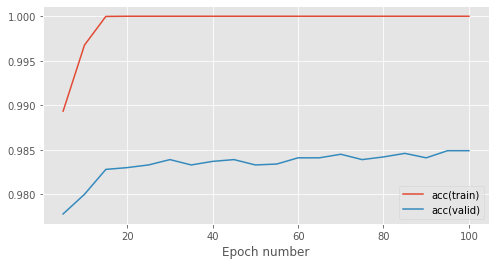

    final error(train) = 1.141e-03
    final error(valid) = 6.475e-02
    final acc(train)   = 1.000e+00
    final acc(valid)   = 9.849e-01
    run time per epoch = 2.429


MultiLayerModel(
    AffineLayer(input_dim=784, output_dim=300)
    ReluLayer
    AffineLayer(input_dim=300, output_dim=150)
    ReluLayer
    AffineLayer(input_dim=150, output_dim=10)
)

In [91]:
run(learning_rate=0.3,
    initializer=UniformInit(-0.05, 0.05),
    hidden_dim=300,
    n_hidden_layers=2,
    learning_rule_cls=lambda learning_rate: MomentumLearningRule(learning_rate, 0.2),
    regularizer='L2',
    regularizer_lambda=2e-5)

Using the momentum-adapted learning rule together with the L2-regularizer we achieve an accuracy of __98.49%__.